# Energy Consumption by household in the UK


In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

import math

from sklearn import decomposition

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

import warnings
warnings.filterwarnings('ignore')
import joblib

<ipython-input-1-5bcd47c041a9>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## PreProcessing

In [9]:
# Importing the final dataset #
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario3.csv',
                             keep_default_na=False)

In [10]:
weather_energy.columns

Index(['time', 'year', 'month', 'day', 'weekday', 'hour', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'weekend'],
      dtype='object')

In [11]:
weather_energy.drop('time', axis=1, inplace=True)

Using lags of upto 12 hours we are going to convert this into a supervised problem. 

In [12]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'energy(kWh/hh)']
dataset = dataframe.values
dataset = dataset.astype('float32')

Next, data is reframed to work for a supervised prediction model

In [13]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Reference: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [14]:
reframed = series_to_supervised(dataset, 24,1)
reframed.head(3)

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,0.127,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,0.178,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,0.352,0.215,0.135,0.091,0.112,0.893,0.453,0.237,0.283,0.231,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054


In [15]:
# Select required columns and merge with supervised data
df = weather_energy
df = df[12:]
reframed = pd.concat([df, reframed], axis=1).dropna()
reframed

,year,month,day,weekday,hour,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
24,2011,11,26,5,23,0.072,13.70,232,11.59,7.18,...,1.106,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072
25,2011,11,27,6,0,0.091,14.13,229,11.98,7.98,...,1.052,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091
26,2011,11,27,6,0,0.054,14.13,229,11.98,7.98,...,0.300,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054
27,2011,11,27,6,1,0.068,13.60,233,12.08,8.28,...,0.346,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068
28,2011,11,27,6,1,0.084,13.60,233,12.08,8.28,...,0.390,0.902,0.380,0.723,0.170,0.072,0.091,0.054,0.068,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39547,2014,1,30,3,2,0.080,4.78,40,4.18,2.69,...,0.341,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080
39548,2014,2,4,1,5,0.067,13.81,225,5.63,2.26,...,0.085,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067
39549,2014,2,9,6,17,0.406,12.15,231,6.72,-1.73,...,0.827,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406
39550,2014,2,15,5,7,0.145,12.39,228,8.59,2.30,...,0.070,0.720,0.198,0.322,0.115,2.586,0.080,0.067,0.406,0.145


In [16]:
reframed = reframed.reindex(reframed.columns, axis=1)
reframed = reframed.values
reframed

array([[2.01100000e+03, 1.10000000e+01, 2.60000000e+01, ...,
        7.22999990e-01, 1.70000002e-01, 7.19999969e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        1.70000002e-01, 7.19999969e-02, 9.09999982e-02],
       [2.01100000e+03, 1.10000000e+01, 2.70000000e+01, ...,
        7.19999969e-02, 9.09999982e-02, 5.40000014e-02],
       ...,
       [2.01400000e+03, 2.00000000e+00, 9.00000000e+00, ...,
        7.99999982e-02, 6.70000017e-02, 4.05999988e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        6.70000017e-02, 4.05999988e-01, 1.44999996e-01],
       [2.01400000e+03, 2.00000000e+00, 1.50000000e+01, ...,
        4.05999988e-01, 1.44999996e-01, 3.47999990e-01]])

**Normalization**

The last 48 readings, corresponding to 24h, are set as the testing set, and the rest is training set

In [17]:
# split into train and test sets
train = reframed[:(len(reframed)-48), :]
test = reframed[(len(reframed)-48):len(reframed), :]

To avoid certain features on higher scales overly-affecting the model, all continous data needs to be scaled.   

In [18]:
# PreProcessing of dataset to feed to models
scaler = MinMaxScaler(feature_range=(0, 1))

Data is split between target variable and independent variables

In [19]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

The scaler must be fit on just the training set, to prevent overfitting (which means the prediction model following the trends of the training set too closely and therefore including noise in its prediction, which reduces its performance on the test set).

In [20]:
# Fit on training data and normalize it
train_X = scaler.fit_transform(train_X)

In [21]:
# Tranform the test set
test_X = scaler.transform(test_X)

In [22]:
train_X.shape

(39480, 40)

## Household energy models

Models are created separately. Lists are held with their performances, so a dataframe can be plotted at the end to compare them.

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []
train_times = []
models_predictions = ['MLR', 'SVM', 'RF', 'FFNNs', 'LSTM', 'RNN', 'Dense+LSTM']

### multiple linear regression (MLR)

The model is fit on the training set.

In [25]:
from sklearn import linear_model
import time
model = linear_model.LinearRegression()
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)
model.coef_

Training time: 0.038 s


array([ 2.90036857e-10,  3.45590086e-10, -1.20846131e-11,  7.39727671e-11,
        3.76299349e-10,  4.89500000e+00, -3.82324476e-10,  2.84592467e-11,
       -1.02579563e-09,  2.09230996e-09, -3.64209485e-10, -1.09671724e-09,
       -5.01168634e-11, -1.43137954e-09, -2.53796359e-09, -7.04237955e-11,
       -1.92044318e-11, -1.64770435e-09,  1.39931299e-10,  1.87436312e-09,
       -1.21743193e-09, -1.94801255e-09,  1.13687115e-09,  2.49193995e-09,
        5.85494590e-10, -1.70329129e-09, -2.38397282e-10, -6.63544449e-10,
       -3.13985800e-10, -4.83278996e-10,  1.76337466e-09,  1.78840662e-09,
        1.40510515e-09,  1.56430969e-10, -7.19389916e-10, -1.76763519e-10,
       -1.77372476e-09,  3.97199135e-09,  2.39259784e-09,  2.18429391e-09])

A prediction is made on the test set.

In [26]:
# make a prediction
yhat = model.predict(test_X)

In [27]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Then, the prediction is compared to the true target feature values, and the model's performance is calculated. 

In [28]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999999999999999
Mse:  0.000000000000000
Rmse: 0.000000010188454
Mae:  0.000000006249464
Mape:  0.000001999052274
Training time: 0.038 s


In [29]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

In [30]:
import matplotlib
import seaborn as sns

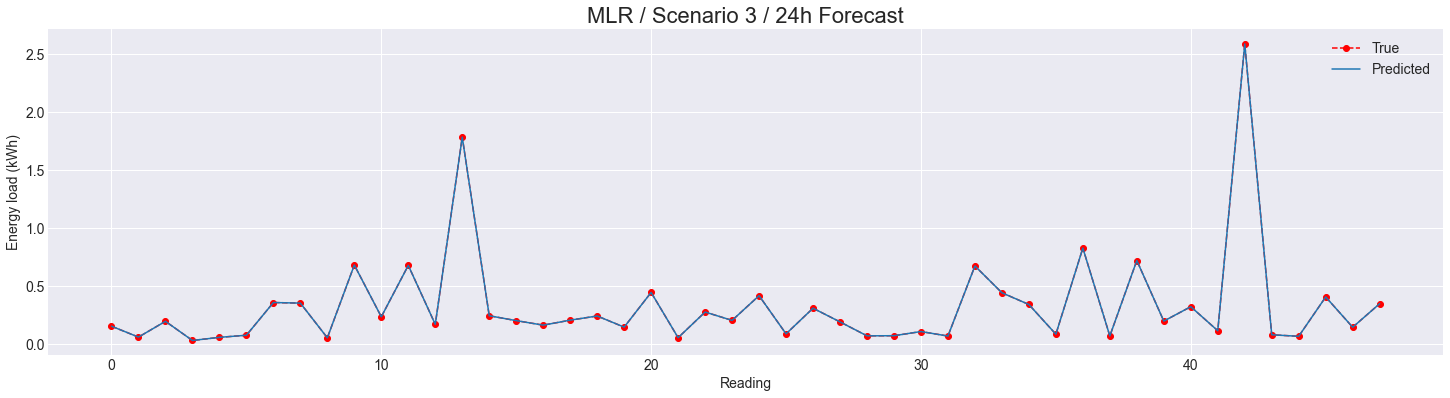

In [32]:
matplotlib.rcParams.update({'font.size': 14})
predicted_mreg = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_mreg['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_mreg['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('MLR / Scenario 3 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/1_allHouseholds/S3_24h_MLR.jpeg', dpi = 500)
plt.show()


The model is predicting almost perfectly.

In [ ]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario3.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario3.joblib']

### support vector regressor (SVR)

In [33]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

In [34]:
model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 0.210 s


**Prediction**

In [35]:
# make a prediction
yhat = model.predict(test_X)

In [36]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999994884230651
Mse:  0.000000993483204
Rmse: 0.000996736276090
Mae:  0.000712949461502
Mape:  0.455602564250706
Training time: 0.210 s


In [37]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

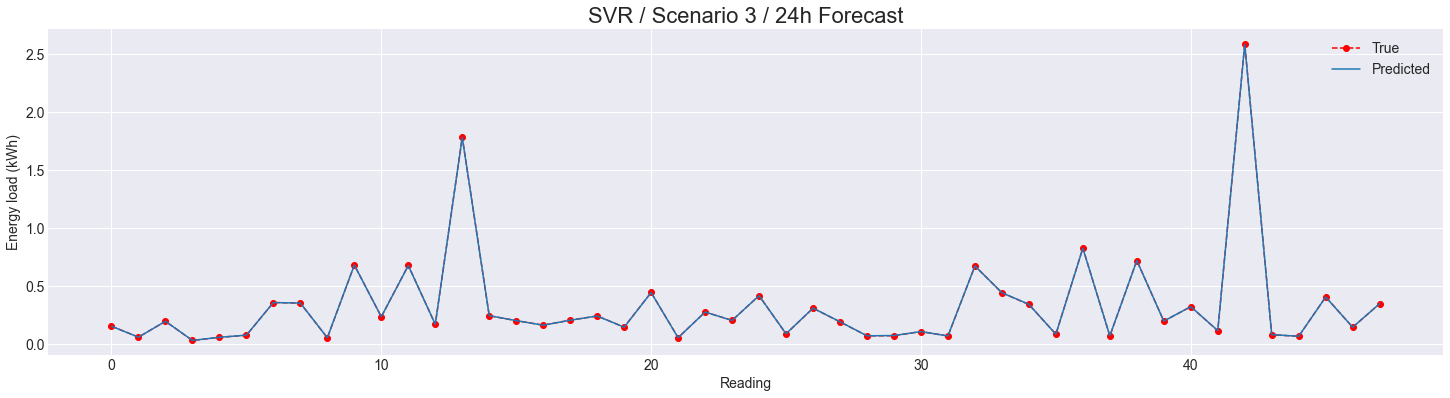

In [38]:
matplotlib.rcParams.update({'font.size': 14})
predicted_svm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_svm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_svm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('SVR / Scenario 3 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/1_allHouseholds/S3_24h_SVR.jpeg', dpi = 500)
plt.show()

### random forest (RF)

In [39]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [40]:
model = RandomForestRegressor(bootstrap= True,
                              max_depth= 110,
                              max_features= 0.33,
                              min_samples_leaf= 3,
                              min_samples_split= 10,
                              n_estimators= 100, 
                              criterion='mse')
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 24.113 s


**Prediction**

In [41]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],1)

**Prediction**

In [42]:
# make a prediction
yhat = model.predict(test_X)

In [43]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.973264745178674
Mse:  0.004084845319896
Rmse: 0.063912794649399
Mae:  0.018124984932970
Mape:  4.786051982945941
Training time: 24.113 s


In [44]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

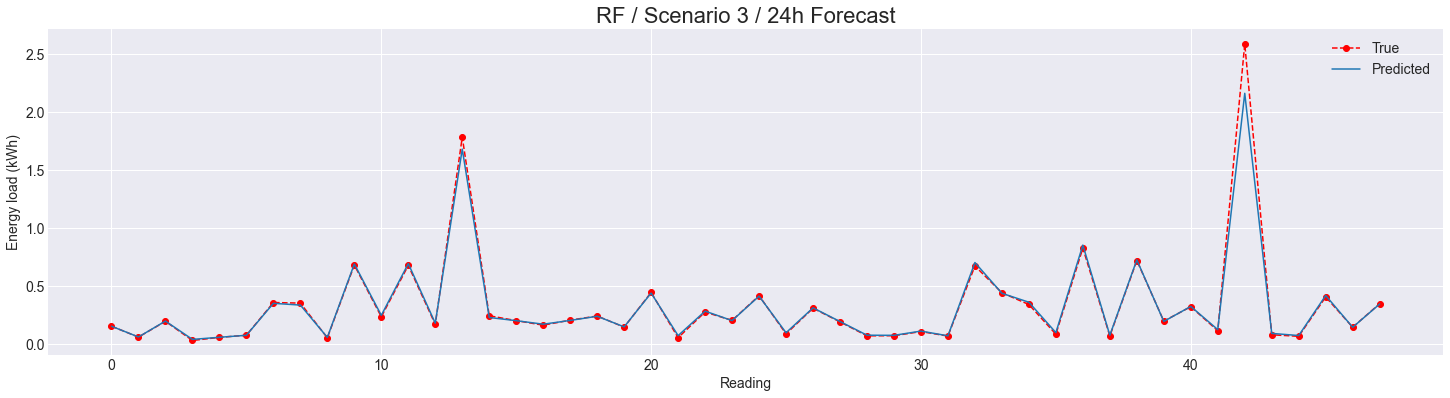

In [45]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rf = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rf['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rf['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RF / Scenario 3 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/1_allHouseholds/S3_24h_RF.jpeg', dpi = 500)
plt.show()

The model is predicting very well, picking up on very fine energy consumption trends

### feedforward neural networks (FFNNs)

In [46]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(39480, 1, 40) (39480,) (48, 1, 40) (48,)


In [47]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers import GRU
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers import TimeDistributed
import keras
from keras import layers

In [48]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [49]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [50]:
from keras.optimizers import RMSprop

Epoch 1/10
7896/7896 - 5s - loss: 0.0078
Epoch 2/10
7896/7896 - 5s - loss: 7.5679e-04
Epoch 3/10
7896/7896 - 5s - loss: 4.1569e-04
Epoch 4/10
7896/7896 - 5s - loss: 3.0717e-04
Epoch 5/10
7896/7896 - 5s - loss: 2.4070e-04
Epoch 6/10
7896/7896 - 4s - loss: 1.9402e-04
Epoch 7/10
7896/7896 - 5s - loss: 1.6092e-04
Epoch 8/10
7896/7896 - 4s - loss: 1.4506e-04
Epoch 9/10
7896/7896 - 4s - loss: 1.3115e-04
Epoch 10/10
7896/7896 - 4s - loss: 1.2302e-04


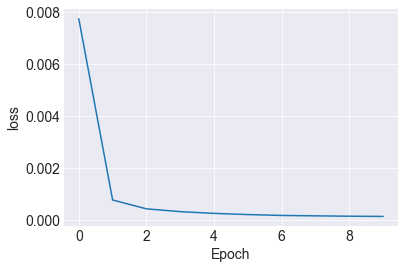

Training time: 46.573 s


In [51]:
model = Sequential()

# Add fully connected layer with a ReLU activation function
model.add(Dense(units=64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=64, activation='relu'))

# Add fully connected layer with no activation function
model.add(Dense(units=1))

optimizer = keras.optimizers.RMSprop(lr=0.001, momentum= 0.9)

model.compile(loss='mean_squared_error', # Mean squared error
            optimizer ='RMSprop' # Optimization algorithm
            )

start_time = time.time()
history = model.fit(train_X, train_y, epochs=10, batch_size=5, verbose=2, shuffle=False) 
end_time = time.time()
train_time = end_time - start_time
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [52]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [53]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999262001889079
Mse:  0.000141272769639
Rmse: 0.011885822211322
Mae:  0.011528092281272
Mape:  7.651120685410191
Training time: 46.573 s


In [54]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

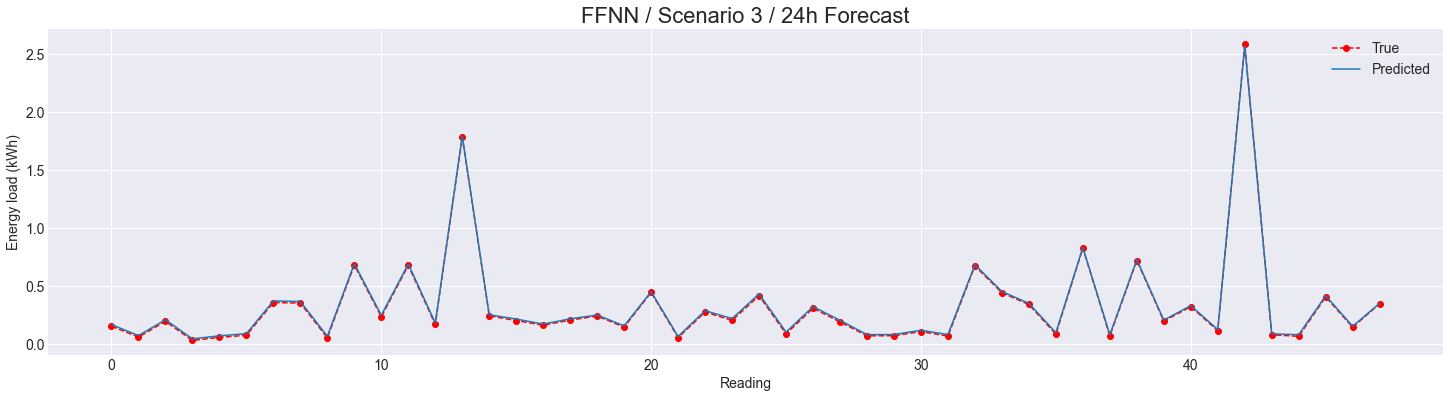

In [55]:
matplotlib.rcParams.update({'font.size': 14})
predicted_fnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_fnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_fnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('FFNN / Scenario 3 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/1_allHouseholds/S3_24h_FFNN.jpeg', dpi = 500)
plt.show()

Good predictions, although a bit worse compared to the RF.

### LSTM

In [56]:
from keras.wrappers.scikit_learn import KerasRegressor
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [57]:
from keras.optimizers import Adam

Epoch 1/30
1645/1645 - 2s - loss: 0.0328
Epoch 2/30
1645/1645 - 2s - loss: 8.7352e-04
Epoch 3/30
1645/1645 - 2s - loss: 9.7505e-04
Epoch 4/30
1645/1645 - 2s - loss: 4.8688e-04
Epoch 5/30
1645/1645 - 2s - loss: 2.0203e-04
Epoch 6/30
1645/1645 - 2s - loss: 2.4270e-04
Epoch 7/30
1645/1645 - 2s - loss: 3.3675e-04
Epoch 8/30
1645/1645 - 2s - loss: 1.8596e-04
Epoch 9/30
1645/1645 - 2s - loss: 2.5340e-04
Epoch 10/30
1645/1645 - 2s - loss: 2.5581e-04
Epoch 11/30
1645/1645 - 2s - loss: 2.0073e-04
Epoch 12/30
1645/1645 - 2s - loss: 3.0007e-04
Epoch 13/30
1645/1645 - 2s - loss: 1.6797e-04
Epoch 14/30
1645/1645 - 2s - loss: 2.5866e-04
Epoch 15/30
1645/1645 - 2s - loss: 3.9434e-04
Epoch 16/30
1645/1645 - 2s - loss: 1.3503e-04
Epoch 17/30
1645/1645 - 2s - loss: 3.9287e-04
Epoch 18/30
1645/1645 - 2s - loss: 1.2625e-04
Epoch 19/30
1645/1645 - 2s - loss: 2.5420e-04
Epoch 20/30
1645/1645 - 2s - loss: 1.8471e-04
Epoch 21/30
1645/1645 - 2s - loss: 3.3569e-04
Epoch 22/30
1645/1645 - 2s - loss: 1.0165e-04
E

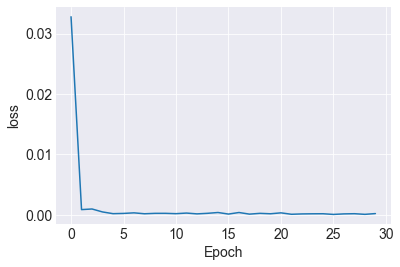

Training time: 54.454 s


In [58]:
# design network
model = Sequential()
model.add(LSTM(128,  activation='softplus', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [59]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [60]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999918082056641
Mse:  0.000016006683733
Rmse: 0.004000835379391
Mae:  0.003580643368574
Mape:  3.581879453861566
Training time: 54.454 s


In [61]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

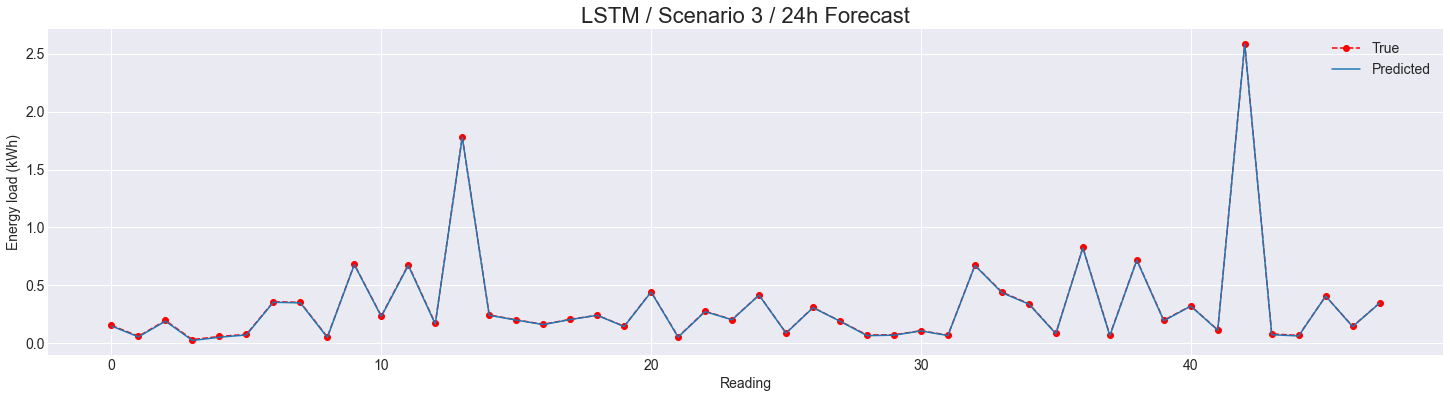

In [62]:
matplotlib.rcParams.update({'font.size': 14})
predicted_lstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_lstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_lstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('LSTM / Scenario 3 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/1_allHouseholds/S3_24h_LSTM.jpeg', dpi = 500)
plt.show()

The model is doing well, better than the previous NN, however not as good as MLR and RF.

### RNN

In [63]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Epoch 1/30
1645/1645 - 1s - loss: 0.0175
Epoch 2/30
1645/1645 - 1s - loss: 5.0121e-04
Epoch 3/30
1645/1645 - 1s - loss: 0.0011
Epoch 4/30
1645/1645 - 2s - loss: 6.3748e-04
Epoch 5/30
1645/1645 - 1s - loss: 9.9498e-04
Epoch 6/30
1645/1645 - 1s - loss: 6.0514e-04
Epoch 7/30
1645/1645 - 1s - loss: 3.0974e-04
Epoch 8/30
1645/1645 - 1s - loss: 4.7809e-04
Epoch 9/30
1645/1645 - 1s - loss: 3.6088e-04
Epoch 10/30
1645/1645 - 1s - loss: 3.8542e-04
Epoch 11/30
1645/1645 - 2s - loss: 2.2487e-04
Epoch 12/30
1645/1645 - 1s - loss: 1.5133e-04
Epoch 13/30
1645/1645 - 2s - loss: 6.3072e-04
Epoch 14/30
1645/1645 - 2s - loss: 1.4520e-04
Epoch 15/30
1645/1645 - 2s - loss: 2.4625e-04
Epoch 16/30
1645/1645 - 1s - loss: 7.3067e-05
Epoch 17/30
1645/1645 - 1s - loss: 1.7043e-04
Epoch 18/30
1645/1645 - 1s - loss: 1.6489e-04
Epoch 19/30
1645/1645 - 1s - loss: 1.0873e-04
Epoch 20/30
1645/1645 - 1s - loss: 2.2837e-04
Epoch 21/30
1645/1645 - 1s - loss: 1.0493e-04
Epoch 22/30
1645/1645 - 1s - loss: 2.1122e-04
Epoch

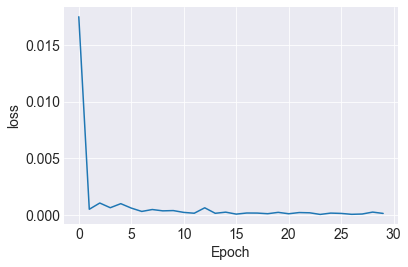

Training time: 40.285 s


In [64]:
# design network
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [65]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario3.h5')

In [66]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario3.h5")
print("Saved model to disk")
 

Saved model to disk


In [67]:
from keras.models import model_from_json


In [68]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario3.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data


Loaded model from disk


**Prediction**

In [69]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [70]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999960258126163
Mse:  0.000007775721996
Rmse: 0.002788498161307
Mae:  0.001782239143116
Mape:  1.038925447901113
Training time: 40.285 s


In [71]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

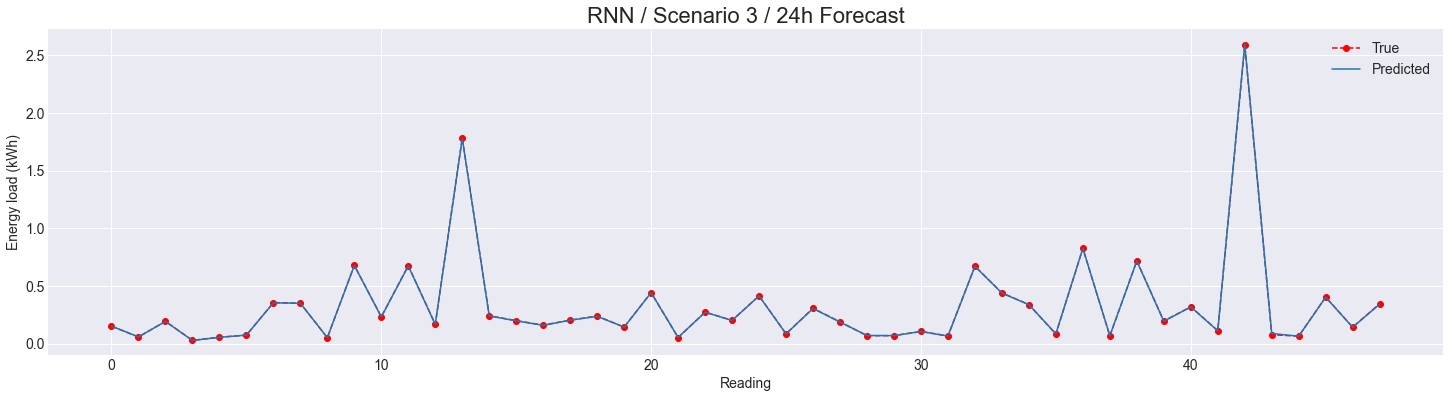

In [72]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN / Scenario 3 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/1_allHouseholds/S3_24h_RNN.jpeg', dpi = 500)
plt.show()

The model is doing well however its accuracy is worse than that of CNN-LSTM. However, it's training 4 times faster. 

Because this model achieved the best performance, saving it:

### Dense + LSTM

In Masterarbeit to fully leverage the neural network achitecture, an LSTM layer is combined with two dense ones. 

Epoch 1/30
617/617 - 1s - loss: 0.0739
Epoch 2/30
617/617 - 1s - loss: 0.0207
Epoch 3/30
617/617 - 1s - loss: 0.0016
Epoch 4/30
617/617 - 1s - loss: 0.0011
Epoch 5/30
617/617 - 1s - loss: 9.1249e-04
Epoch 6/30
617/617 - 1s - loss: 7.9363e-04
Epoch 7/30
617/617 - 1s - loss: 6.8511e-04
Epoch 8/30
617/617 - 1s - loss: 5.9285e-04
Epoch 9/30
617/617 - 1s - loss: 5.0134e-04
Epoch 10/30
617/617 - 1s - loss: 4.4449e-04
Epoch 11/30
617/617 - 1s - loss: 5.1032e-04
Epoch 12/30
617/617 - 1s - loss: 3.4640e-04
Epoch 13/30
617/617 - 1s - loss: 4.7893e-04
Epoch 14/30
617/617 - 1s - loss: 3.5111e-04
Epoch 15/30
617/617 - 1s - loss: 3.7334e-04
Epoch 16/30
617/617 - 1s - loss: 3.2463e-04
Epoch 17/30
617/617 - 1s - loss: 2.8834e-04
Epoch 18/30
617/617 - 1s - loss: 2.5588e-04
Epoch 19/30
617/617 - 1s - loss: 2.7272e-04
Epoch 20/30
617/617 - 1s - loss: 2.0635e-04
Epoch 21/30
617/617 - 1s - loss: 3.2799e-04
Epoch 22/30
617/617 - 1s - loss: 1.9917e-04
Epoch 23/30
617/617 - 1s - loss: 1.8774e-04
Epoch 24/30
6

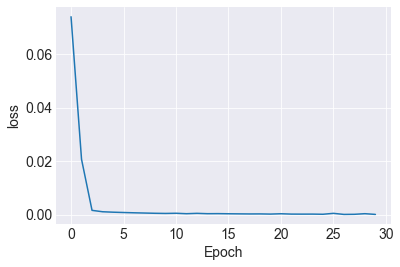

Training time: 35.362 s


In [73]:
# design network
model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(LSTM(128))
model.add(Dense(1))
optimizer = Adam(lr=0.0001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )

#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc']) #mae

start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=64, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [74]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/dense_LSTM_Scenario3_24h.h5')

**Prediction**

In [75]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [76]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999733423668650
Mse:  0.000051693499985
Rmse: 0.007189819189995
Mae:  0.005557653261349
Mape:  3.248987859361505
Training time: 35.362 s


In [77]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

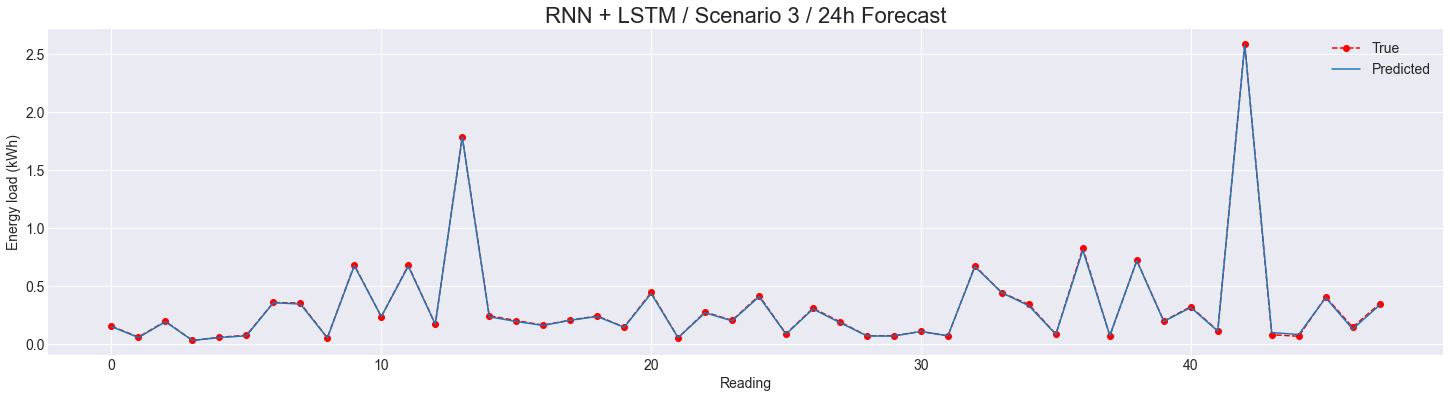

In [78]:
matplotlib.rcParams.update({'font.size': 14})
predicted_denselstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_denselstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_denselstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN + LSTM / Scenario 3 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/1_allHouseholds/S3_24h_RNN_LSTM.jpeg', dpi = 500)
plt.show()

This is the best model, the predictions accurately follow the observed energy consumption.


## Best model

In [ ]:
models_performances = pd.DataFrame([R2_scores,MSE_scores,RMSE_scores,MAE_scores,MAPE_scores,train_times],
                                   columns=models_predictions, 
                                   index=['R2_scores', 'MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores', 'Train_Time'])
models_performances

,MLR,SVM,RF,FFNNs,LSTM,RNN,Dense+LSTM
R2_scores,1.000000e+00,9.999949e-01,0.973265,0.999548,0.999883,0.999541,0.999565
MSE_scores,1.038046e-16,9.934832e-07,0.004085,0.000087,0.000023,0.000087,0.000083
RMSE_scores,1.018845e-08,9.967363e-04,0.063913,0.009310,0.004757,0.009303,0.009113
MAE_scores,6.249464e-09,7.129495e-04,0.018125,0.008536,0.003889,0.002652,0.007367
MAPE_scores,1.999052e-06,4.556026e-01,4.786052,6.425029,3.285726,0.933000,4.139009
Train_Time,4.687381e-02,2.443461e-01,30.320939,51.149189,45.995035,33.329949,33.369825


In [ ]:
models_performances.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/BestModel_Scenario3.csv', index=False)

Most models are returning similar scores, except for the SVM, which is significantly under-performing. 

The best performance, in terms of all the metrics measured except for training time, is the neural network with dense layers combined with LSTM.

**Plotting all models together.**

In [79]:
prev_day = train_y[-48:] #energy readings from previous day
y_plotting = np.concatenate([prev_day, test_y], axis=0)

In [80]:

# Get all predictions from the models
predicted_energy=[predicted_mreg['predicted'],
                  predicted_svm['predicted'],
                  predicted_rf['predicted'],
                  predicted_fnn['predicted'],
                  predicted_lstm['predicted'],
                  predicted_rnn['predicted'],
                  predicted_denselstm['predicted']]

In [81]:
prev_2days = sorted(pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario3.csv').time)[-96:]

In [82]:
df_for_plotting = pd.DataFrame(y_plotting, index=prev_2days, columns=['Original'])

In [83]:
# Initialize all columns with null values
df_for_plotting["Train"] = np.nan
# Add a column for each model's predictions
col_names=['MLR', 'SVR', 'RF', 'FFNN', 'LSTM', 'RNN', 'Dense-LSTM']
for col_name in col_names:
  df_for_plotting[col_name+' forecast'] = np.nan

In [84]:
# Fill in with corresponding values
df_for_plotting["Train"][:-48] = prev_day

for i, model_pred in enumerate(predicted_energy):
  df_for_plotting[col_names[i]+' forecast'][-48:] = model_pred

In [85]:
# Turn index to datetime
df_for_plotting.index = pd.to_datetime(df_for_plotting.index)

In [86]:
df_for_plotting.columns

Index(['Original', 'Train', 'MLR forecast', 'SVR forecast', 'RF forecast',
       'FFNN forecast', 'LSTM forecast', 'RNN forecast',
       'Dense-LSTM forecast'],
      dtype='object')

In [87]:
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

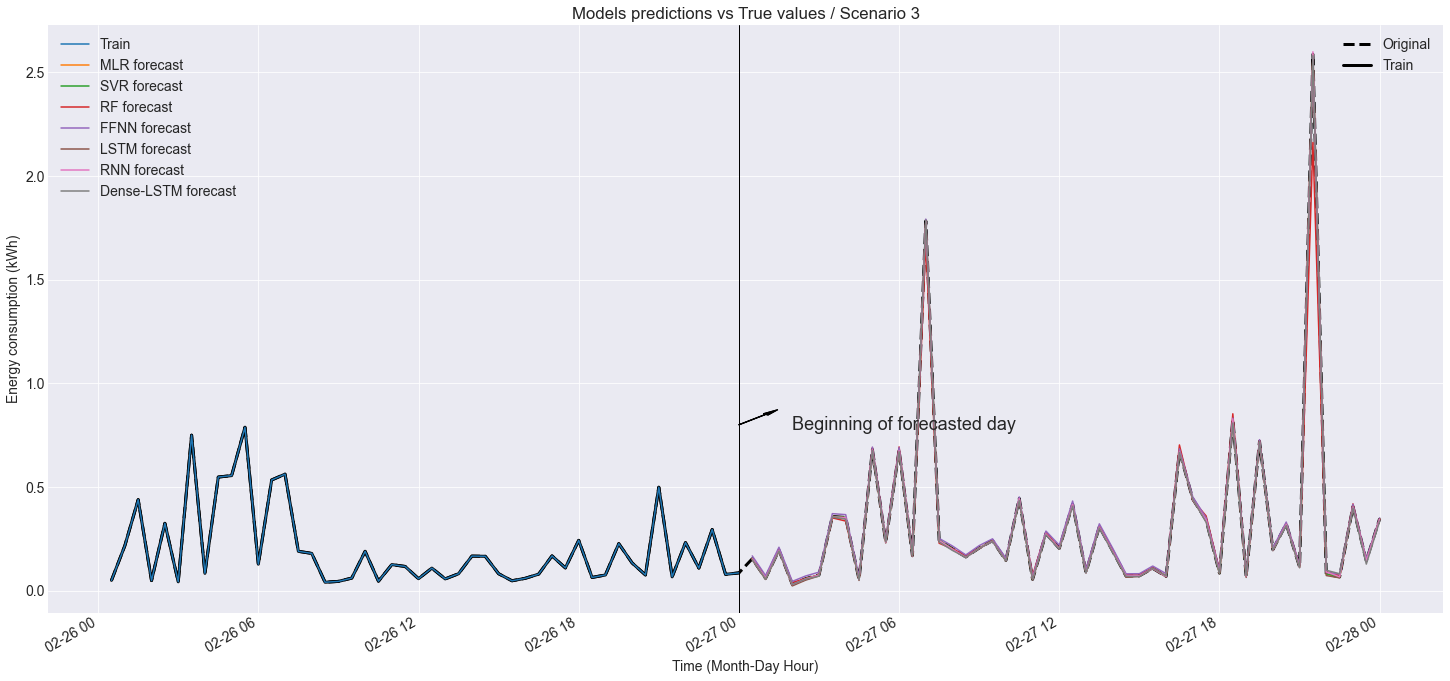

In [88]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)


# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='K', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[1:]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)


# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.8, dx, 0.05, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)


plt.title('Models predictions vs True values / Scenario 3')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/1_allHouseholds/S3_24h_OriginalPredicted_All.jpeg', dpi = 500)
plt.show()

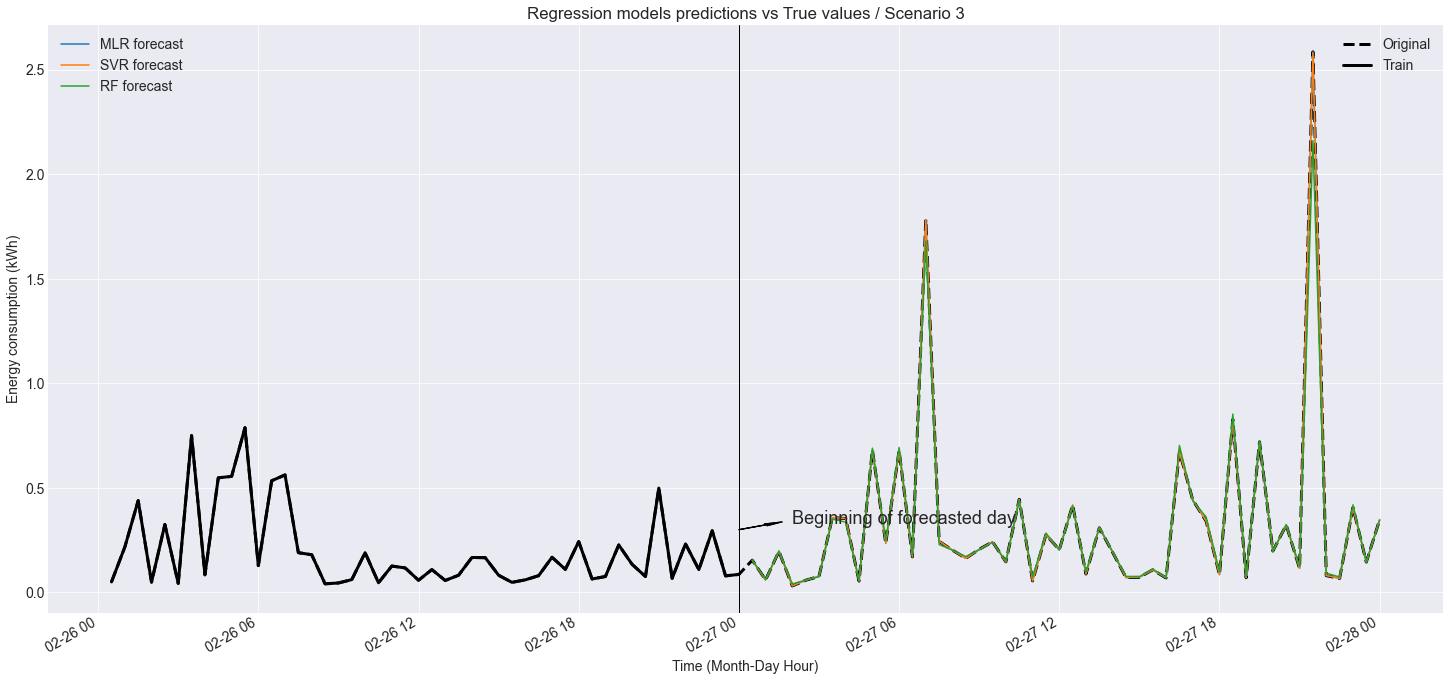

In [89]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[2:5]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.35, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.3, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Regression models predictions vs True values / Scenario 3')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/1_allHouseholds/S3_24h_RegressionModelsPredicted_All.jpeg', dpi = 500)
plt.show()

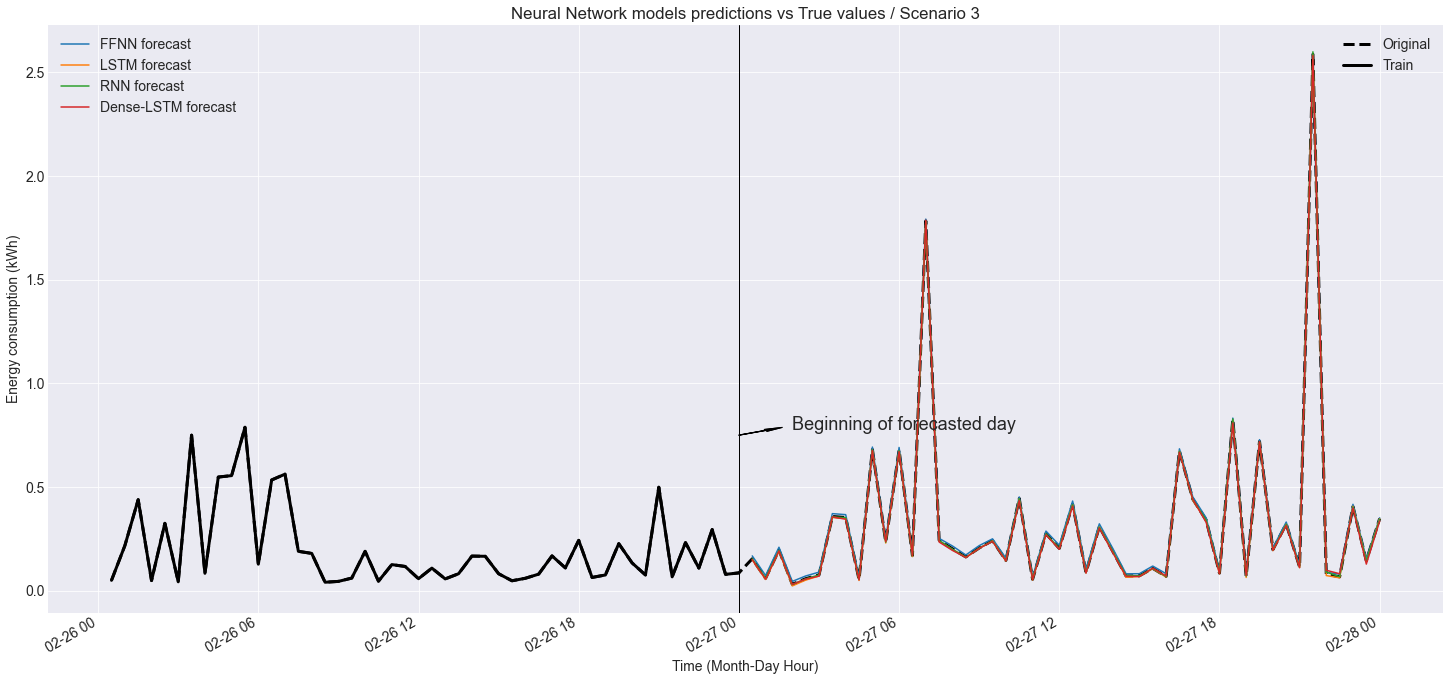

In [90]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[5:]:
  df_for_plotting[forecast].plot()

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.75, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Neural Network models predictions vs True values / Scenario 3')
plt.legend(loc='upper left')
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/1_allHouseholds/S3_24h_OriginalPredicted_4_8.jpeg', dpi = 500)
plt.show()

## House level prediction 
-For each half hour, for each of the 33 types.

In [95]:
houses_data = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/all_houses_Scenario4.csv')

In [96]:
houses_data

,LCLid,tstp,energy(kWh/hh)
0,2,2012-10-12 00:30:00,0.000
1,2,2012-10-12 01:00:00,0.000
2,2,2012-10-12 01:30:00,0.000
3,2,2012-10-12 02:00:00,0.000
4,2,2012-10-12 02:30:00,0.000
...,...,...,...
8092712,5124,2014-02-27 22:00:00,0.673
8092713,5124,2014-02-27 22:30:00,0.590
8092714,5124,2014-02-27 23:00:00,0.552
8092715,5124,2014-02-27 23:30:00,0.519


In [97]:
houses_data.rename(columns={'tstp':'time'}, inplace=True)

Merging with the weather_energy data

In [98]:
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv')

In [99]:
weather_energy.columns

Index(['time', 'year', 'month', 'day', 'hour', 'weekday', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend'],
      dtype='object')

In [100]:
weather_energy = weather_energy.drop(columns = ['stdorToU', 'Acorn', 'Acorn_grouped'])

In [101]:
updated_houses = houses_data.merge(weather_energy, on='time')

In [102]:
updated_houses

,LCLid,time,energy(kWh/hh)_x,year,month,day,hour,weekday,energy(kWh/hh)_y,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday_ind,weekend
0,2,2012-10-12 00:30:00,0.000,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0,0
1,246,2012-10-12 00:30:00,0.975,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0,0
2,1074,2012-10-12 00:30:00,1.438,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0,0
3,3281,2012-10-12 00:30:00,0.078,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0,0
4,3305,2012-10-12 00:30:00,0.101,2012,10,12,0,4,0.135,11.76,234,13.61,12.21,999.47,13.61,5.40,0.91,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8086036,183,2011-12-03 06:30:00,0.109,2011,12,3,6,5,0.109,11.73,244,11.00,10.26,1001.07,11.00,6.37,0.95,0,1
8086037,183,2011-12-03 07:00:00,0.030,2011,12,3,7,5,0.030,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92,0,1
8086038,183,2011-12-03 07:30:00,0.082,2011,12,3,7,5,0.082,11.93,253,10.96,9.73,1001.07,10.96,5.48,0.92,0,1
8086039,183,2011-12-03 08:00:00,0.030,2011,12,3,8,5,0.030,13.71,253,11.01,9.11,1001.55,11.01,6.32,0.88,0,1


In [103]:
updated_houses.columns

Index(['LCLid', 'time', 'energy(kWh/hh)_x', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'holiday_ind', 'weekend'],
      dtype='object')

In [104]:
updated_houses.columns = ['LCLid', 'time', 'energy(kWh/hh)', 'year', 'month', 'day', 'hour',
       'weekday', 'energy(kWh/hh)_y', 'visibility', 'windBearing',
       'temperature', 'dewPoint', 'pressure', 'apparentTemperature',
       'windSpeed', 'humidity', 'holiday_ind', 'weekend']

In [105]:
updated_houses.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S3.csv')

In [106]:
updated_houses = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S3.csv')

In [ ]:
updated_houses.info()

Function to check another household:

In [107]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [108]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [109]:
from keras.models import Sequential, load_model
from joblib import dump, load


In [110]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [111]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-48), :]
  test = reframed[(len(reframed)-48):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  
  # Tranform the test set
  #train_X = scaler.fit_transform(train_X)
  #test_X = scaler.transform(test_X)

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  model = Sequential()
  model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))

  optimizer = Adam(lr=0.001)

  model.compile(loss='mean_squared_error', # Mean squared error
              optimizer = optimizer # Optimization algorithm
              )


  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /RNN (Scenario 3)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/2_singleHouseholdLevel/best_NN_model/S3_24h_LSMT_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


Mse:  40472.881184689504153
Rmse: 201.178729453909966
Mae:  201.151145042385906
Mape:  99.915090503676197


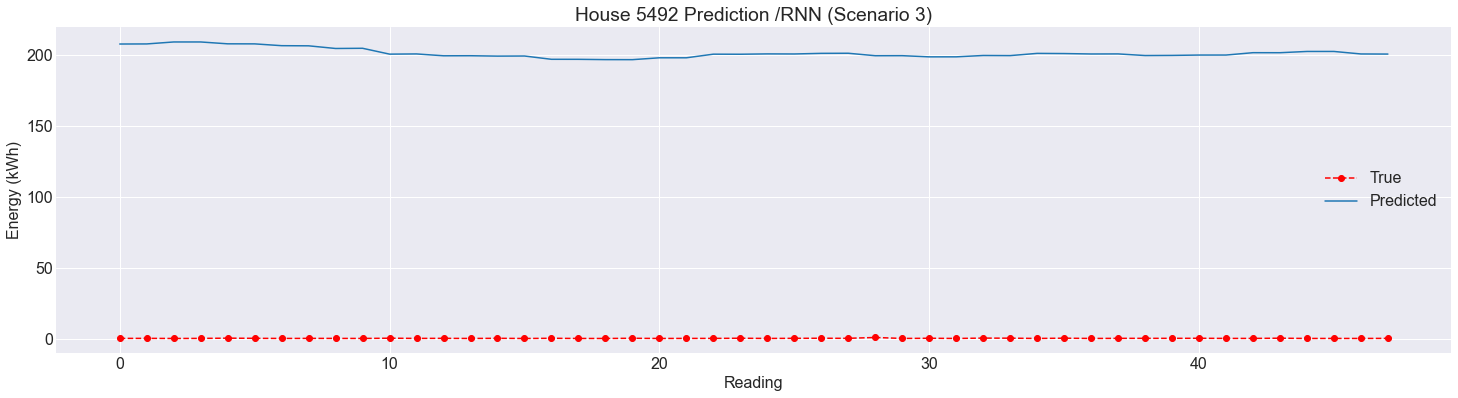

Mse:  25670.878725978454895
Rmse: 160.221342916536742
Mae:  160.186073468687624
Mape:  100.152766742121969


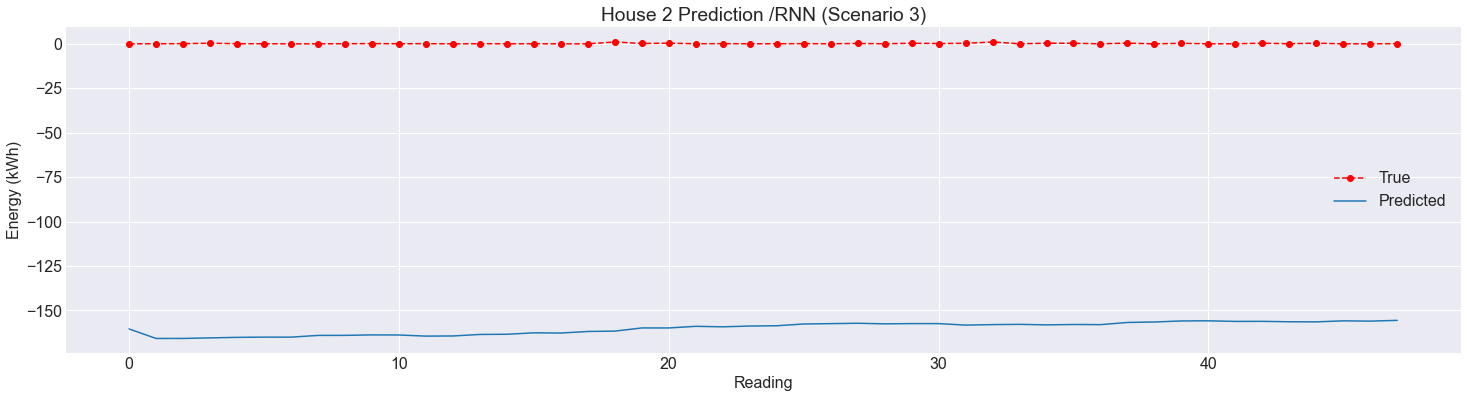

Mse:  142112.412137425038964
Rmse: 376.977999540324674
Mae:  376.917682254997374
Mape:  99.813095145556545


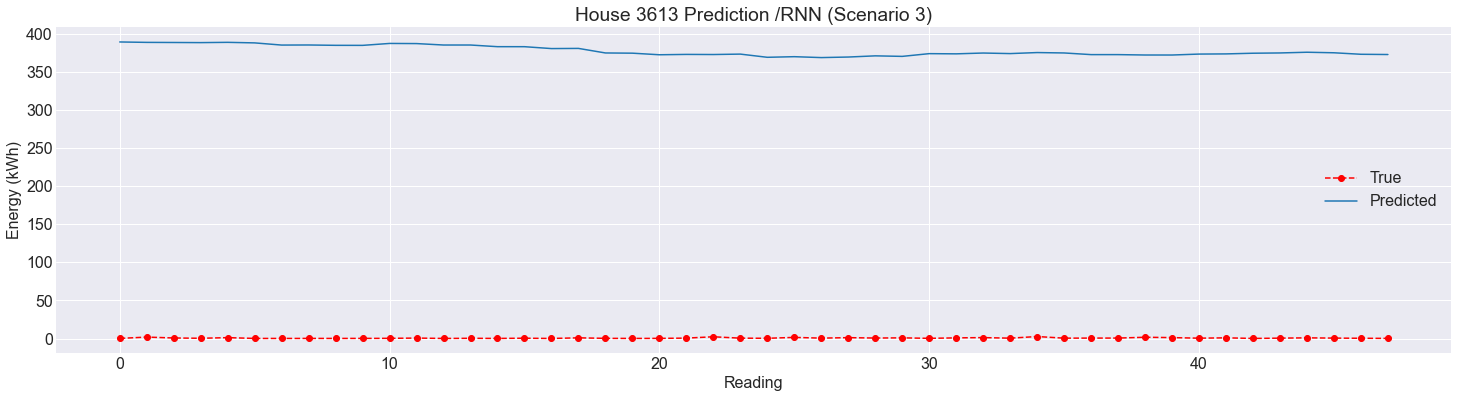

Mse:  102375.175672146127908
Rmse: 319.961209636646629
Mae:  319.959469681760936
Mape:  99.954376517248562


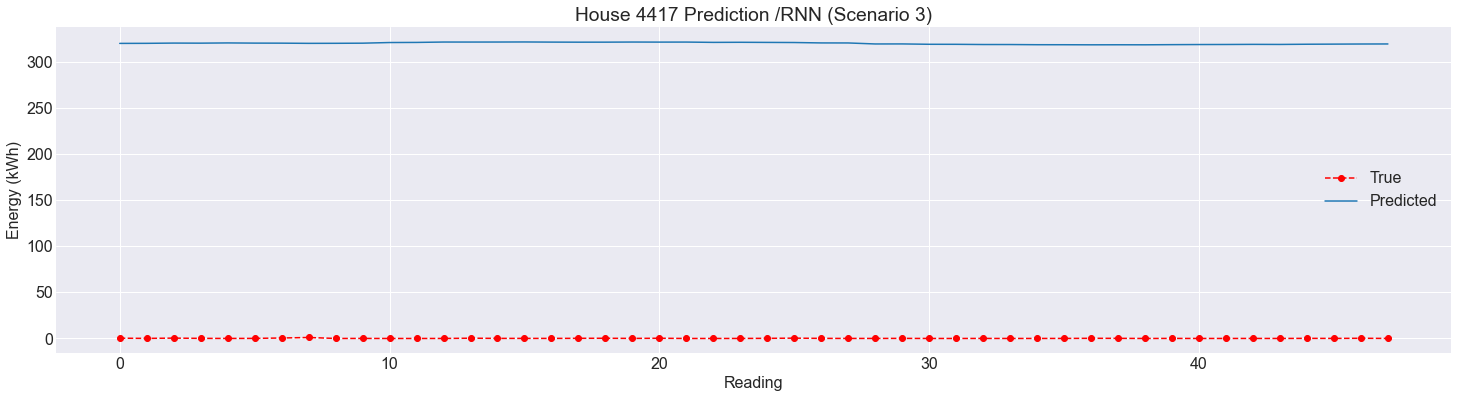

Mse:  42952.985893855970062
Rmse: 207.251021454312678
Mae:  207.246755965580320
Mape:  99.968916249237026


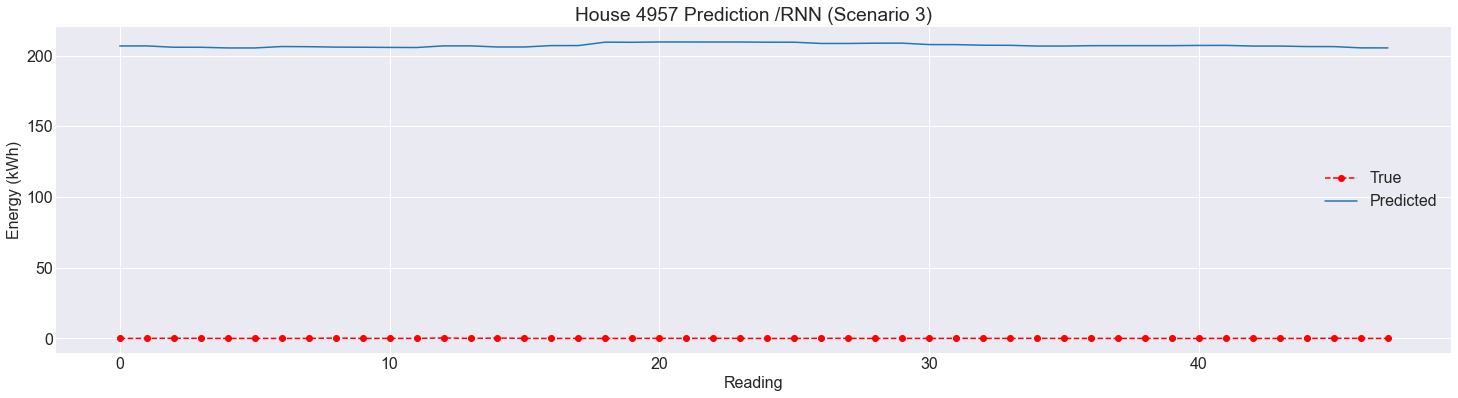

Mse:  138806.541126084572170
Rmse: 372.567498751682024
Mae:  372.559328583845229
Mape:  100.043604555175335


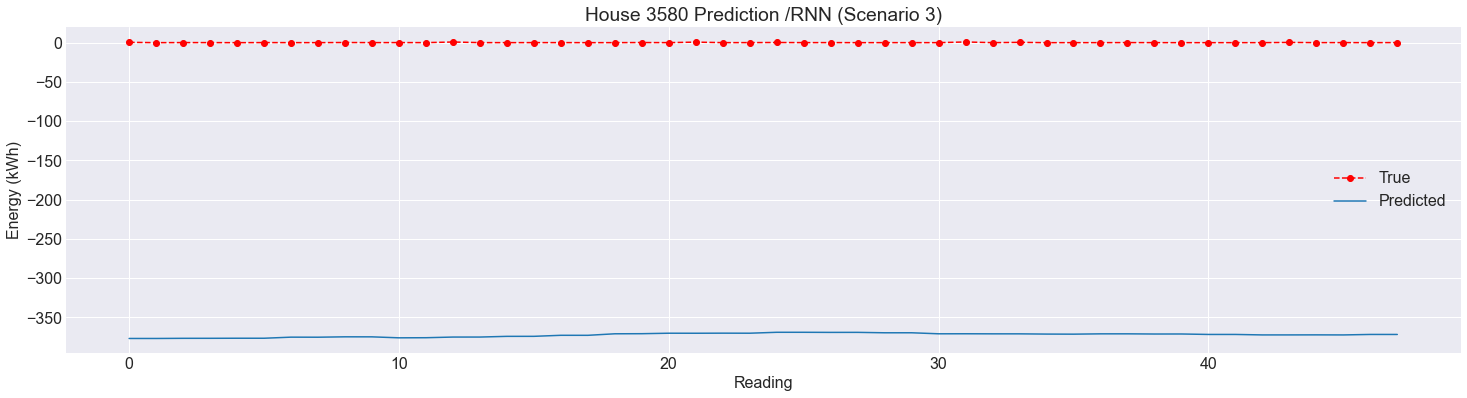

Mse:  18664.956640155451169
Rmse: 136.619752013226304
Mae:  136.585262158031895
Mape:  99.744847512222464


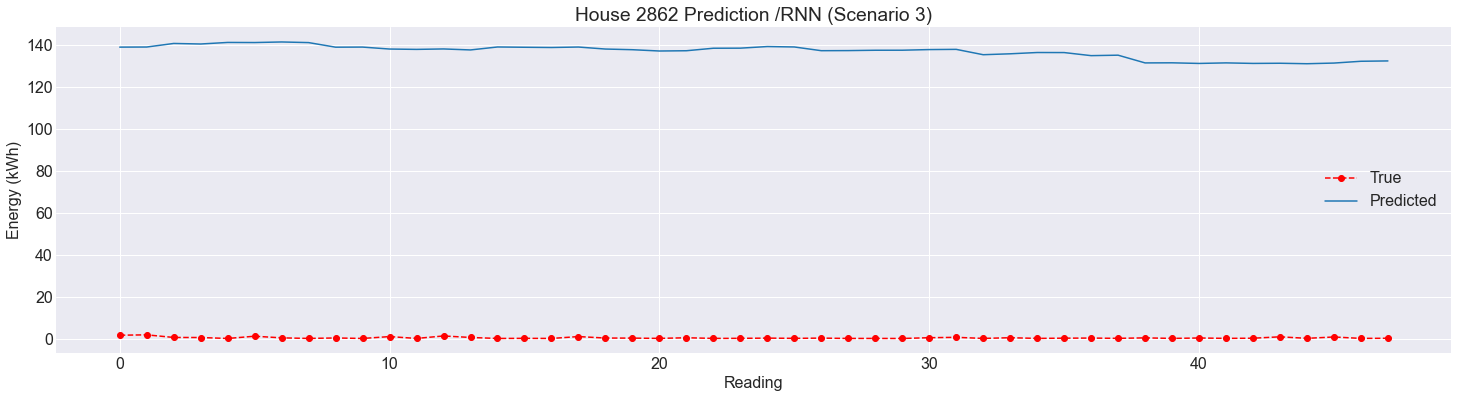

Mse:  29015.176055194053333
Rmse: 170.338416263607598
Mae:  170.329515144151316
Mape:  100.054231504736094


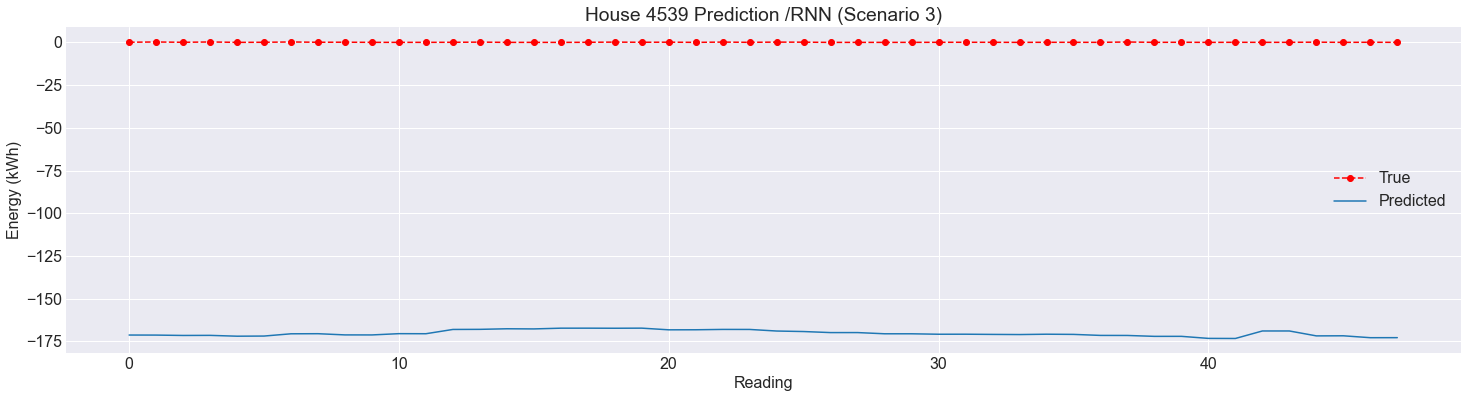

Mse:  18221.775789528186579
Rmse: 134.988057951539503
Mae:  134.981838476650097
Mape:  99.903528867276435


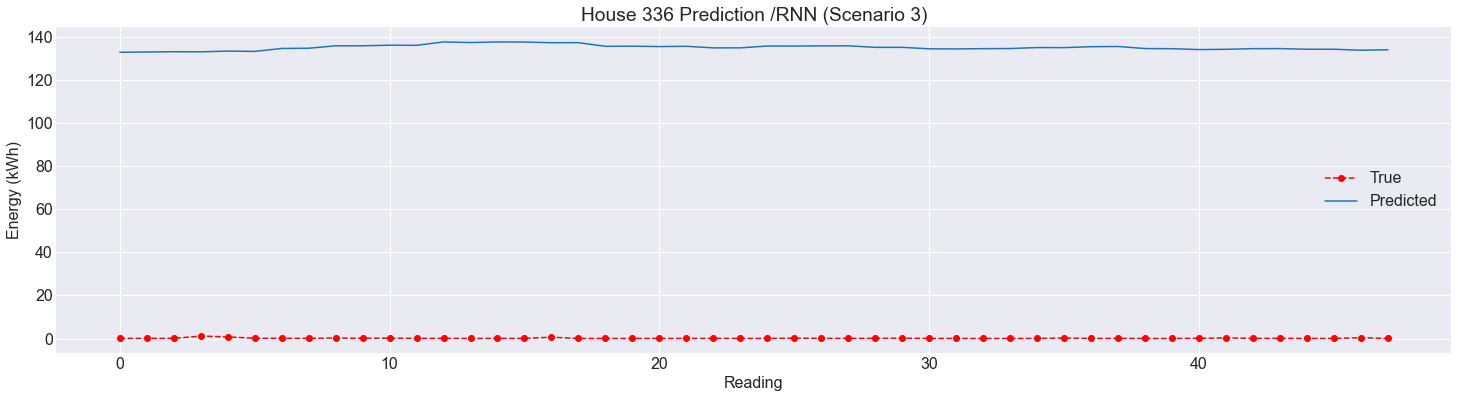

Mse:  88674.769029809860513
Rmse: 297.783090570653201
Mae:  297.782290364149958
Mape:  99.914118497182969


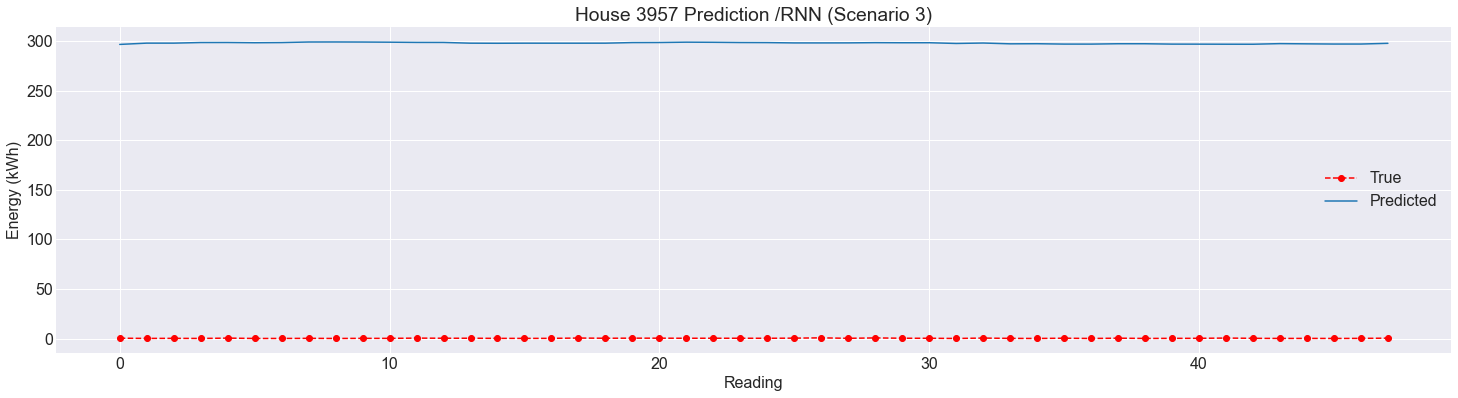

Mse:  29042.970098079571471
Rmse: 170.419981510618555
Mae:  170.417211501393467
Mape:  100.162724689062330


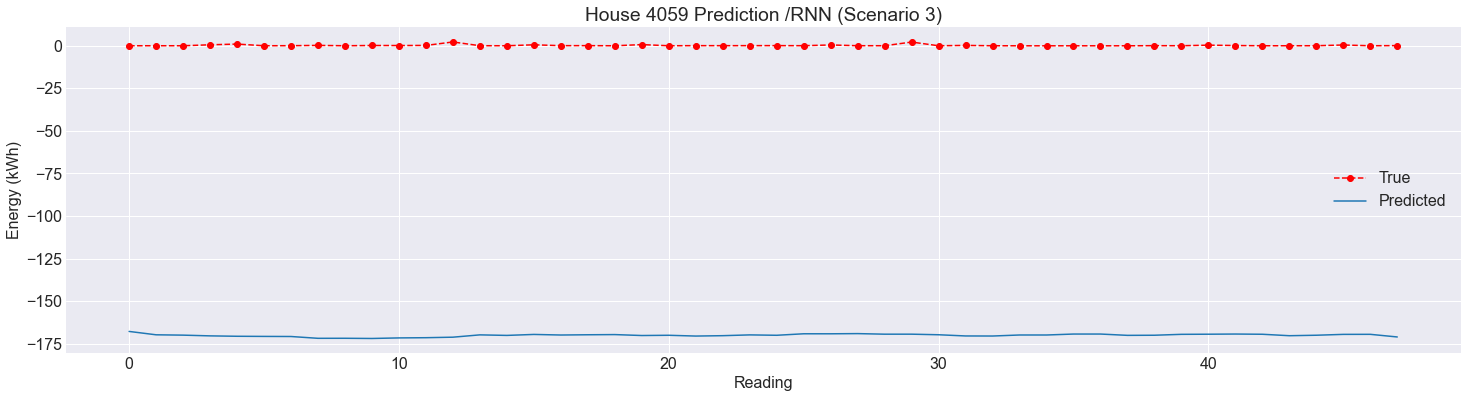

Mse:  100011.288172216343810
Rmse: 316.245613680595341
Mae:  316.214912882559759
Mape:  99.983706582645539


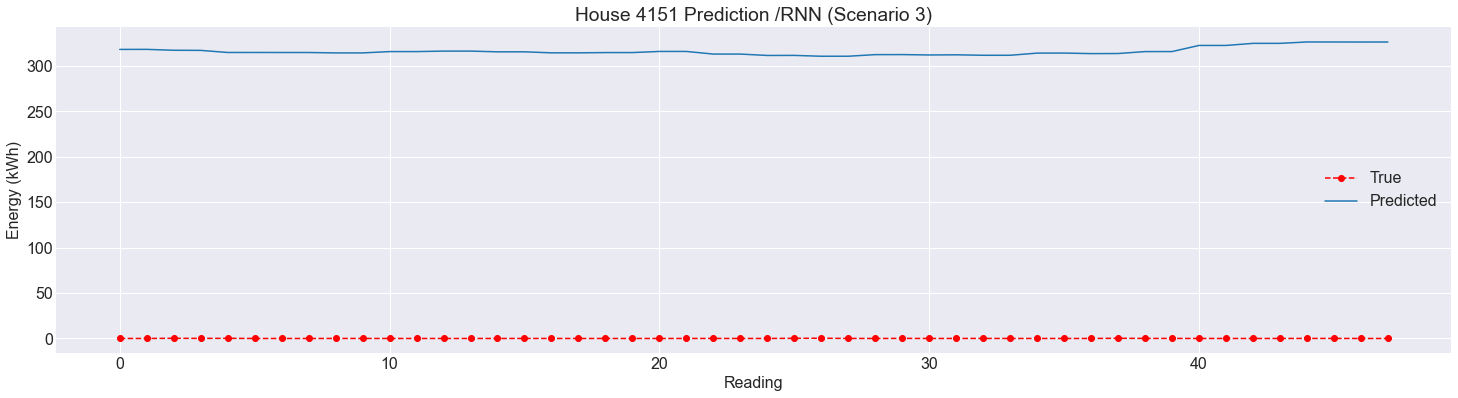

Mse:  2507.481919789535368
Rmse: 50.074763302381527
Mae:  49.882531638412424
Mape:  99.538256305258187


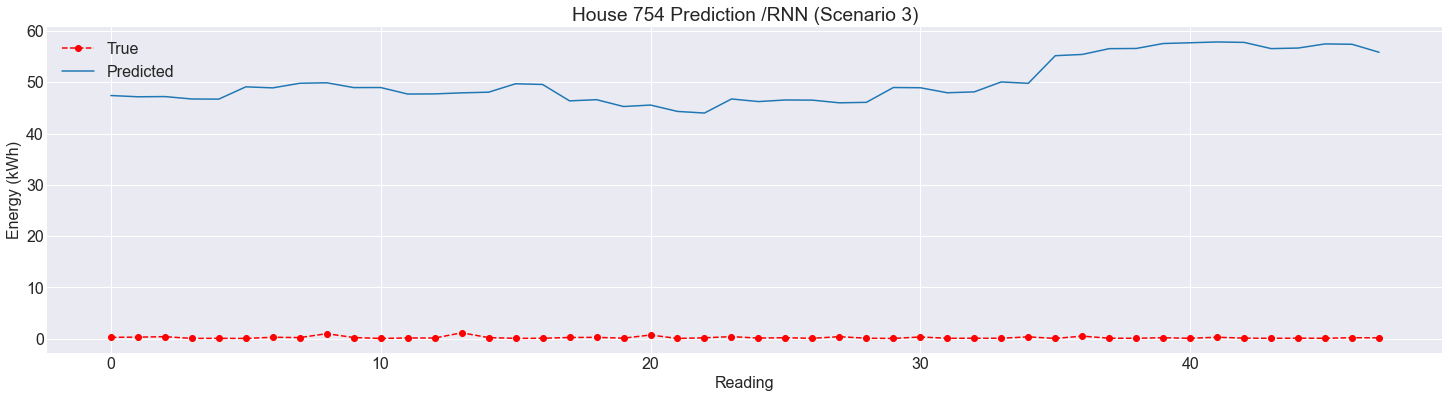

Mse:  105951.910653320301208
Rmse: 325.502550916763653
Mae:  325.496048935048748
Mape:  99.956551375532015


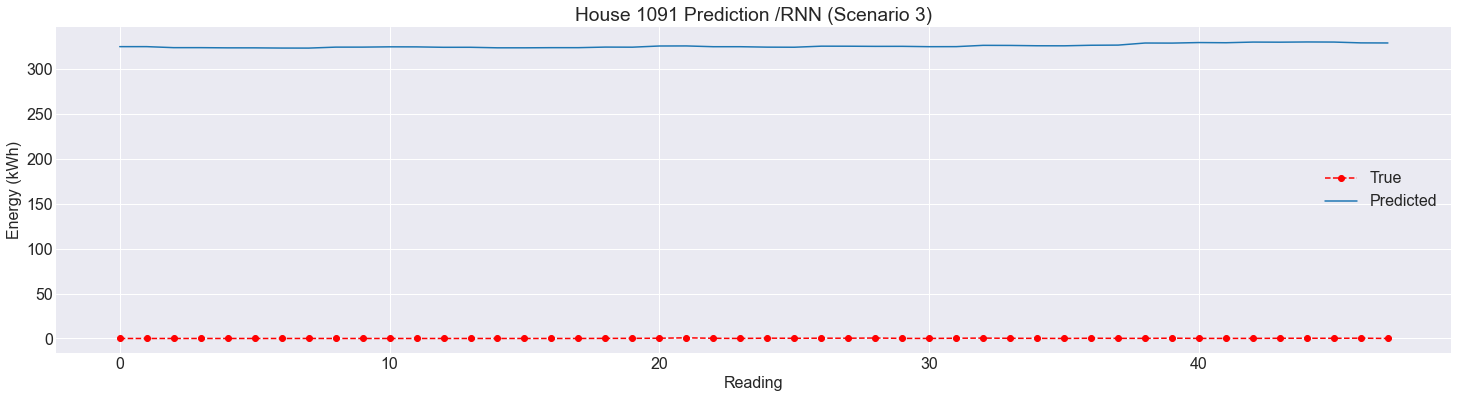

Mse:  2120.964674474570984
Rmse: 46.053932236830448
Mae:  46.041358350620918
Mape:  100.268729712637466


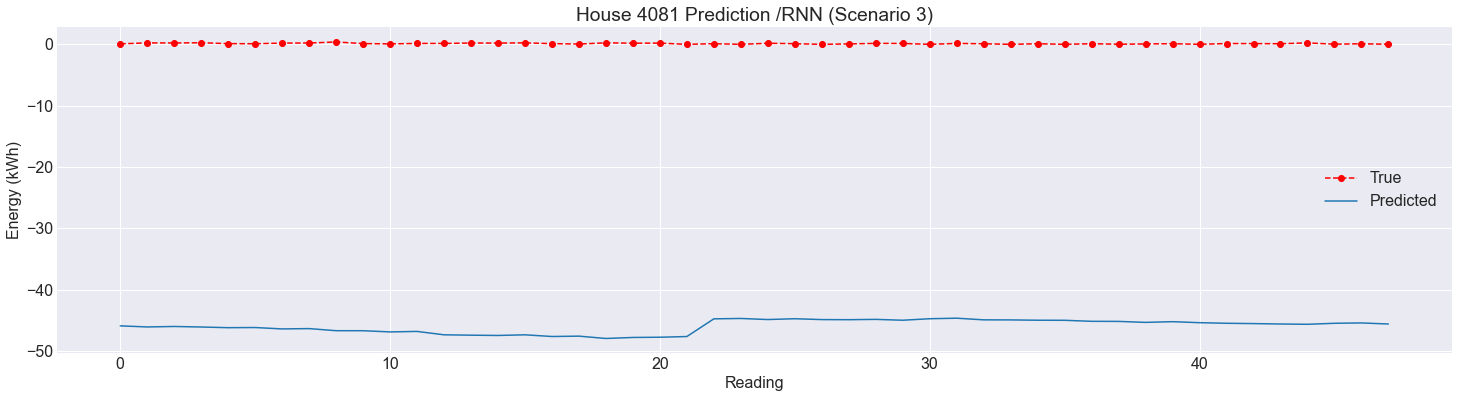

Mse:  207031.393157669110224
Rmse: 455.007025393750496
Mae:  454.973299423077435
Mape:  99.969064479465075


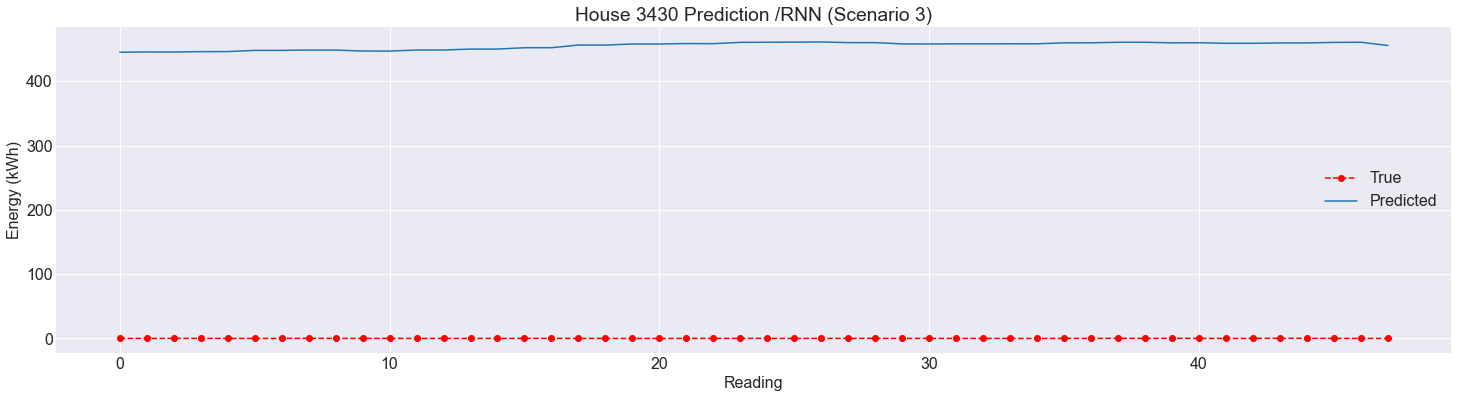

Mse:  855.842245427659350
Rmse: 29.254781582292821
Mae:  29.198011373014499
Mape:  99.022770329321347


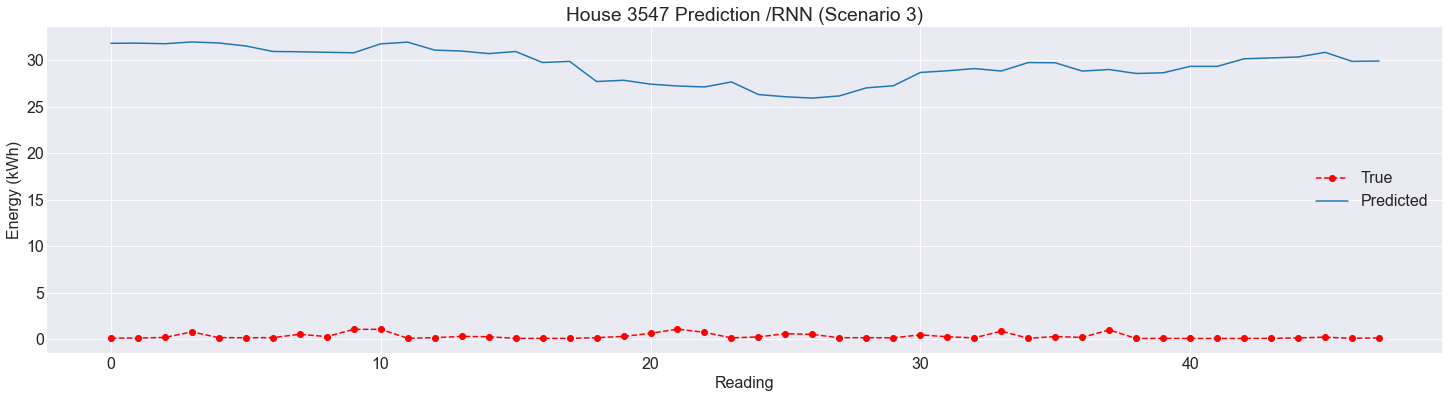

Mse:  752854.741516137379222
Rmse: 867.672024163587594
Mae:  867.663306995915832
Mape:  100.036022772545948


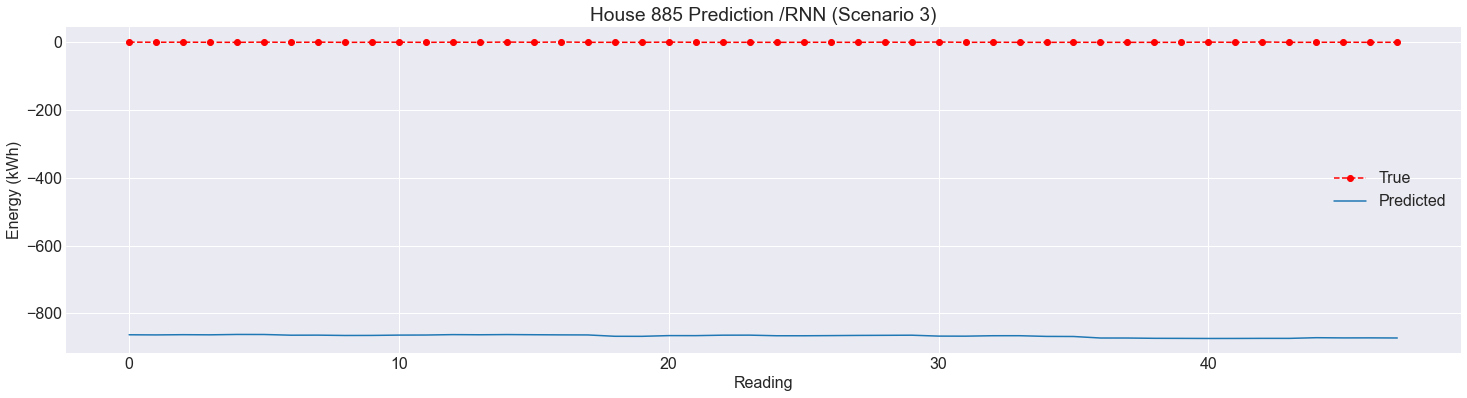

Mse:  189683.744786117604235
Rmse: 435.526973660779845
Mae:  435.521295716209977
Mape:  100.041146843889052


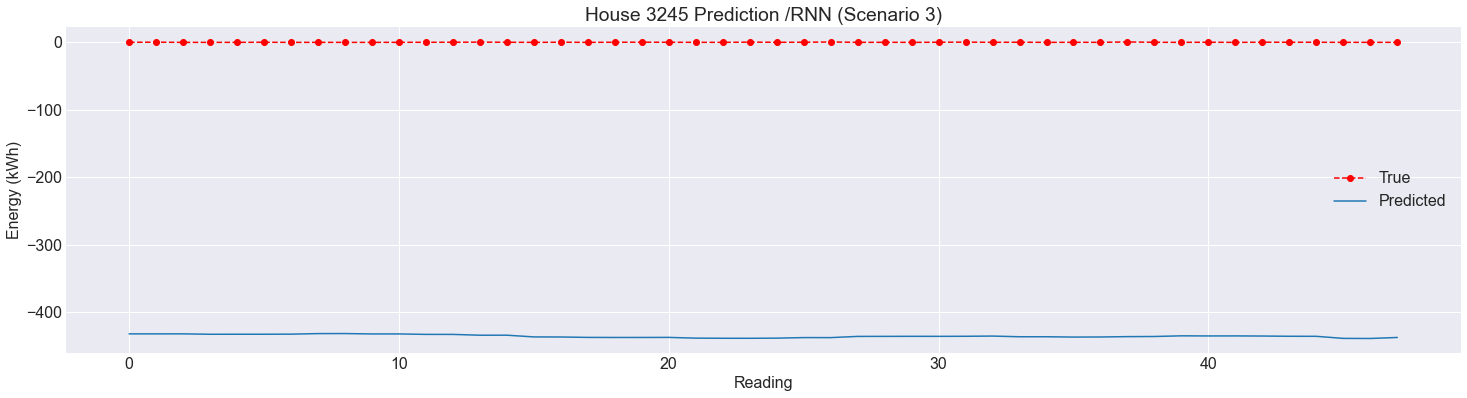

Mse:  4401.411418964468794
Rmse: 66.343133924803922
Mae:  66.311614729774490
Mape:  99.604715209231486


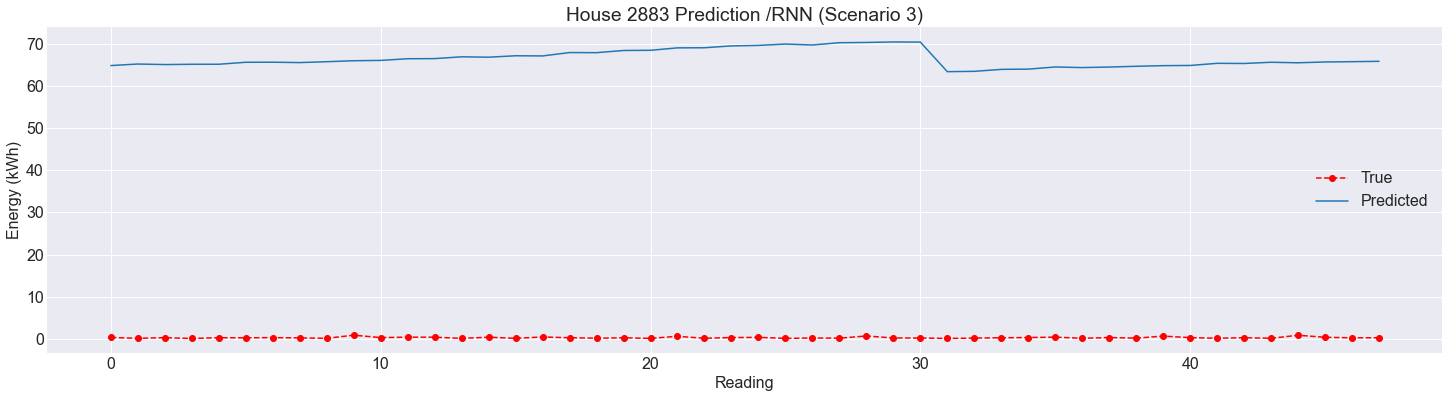

Mse:  49591.318937022042519
Rmse: 222.691084098627641
Mae:  222.676644279815577
Mape:  100.050282027098177


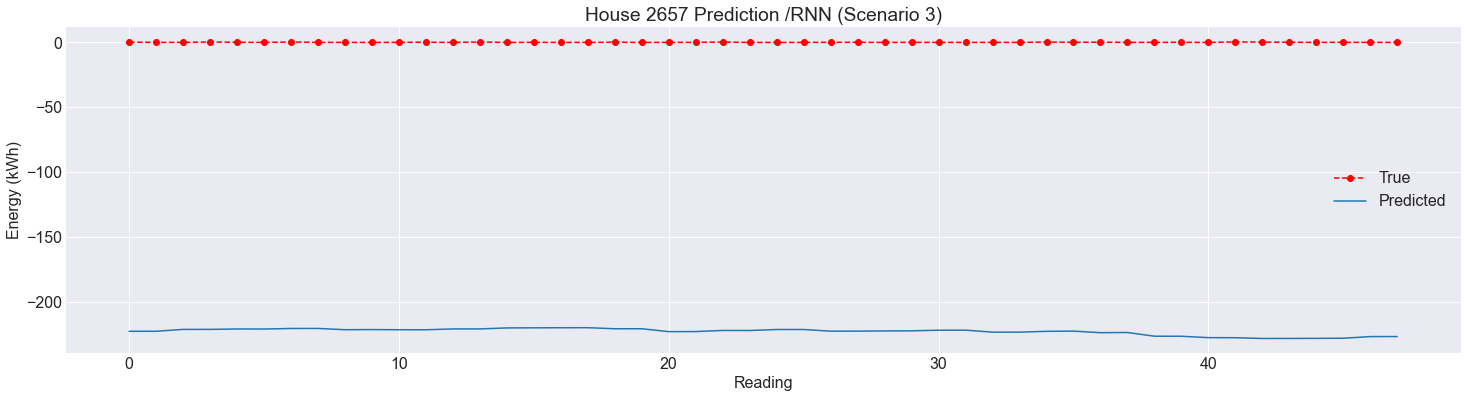

Mse:  12.387143270695779
Rmse: 3.519537366003631
Mae:  3.172688097925857
Mape:  99.970898983651807


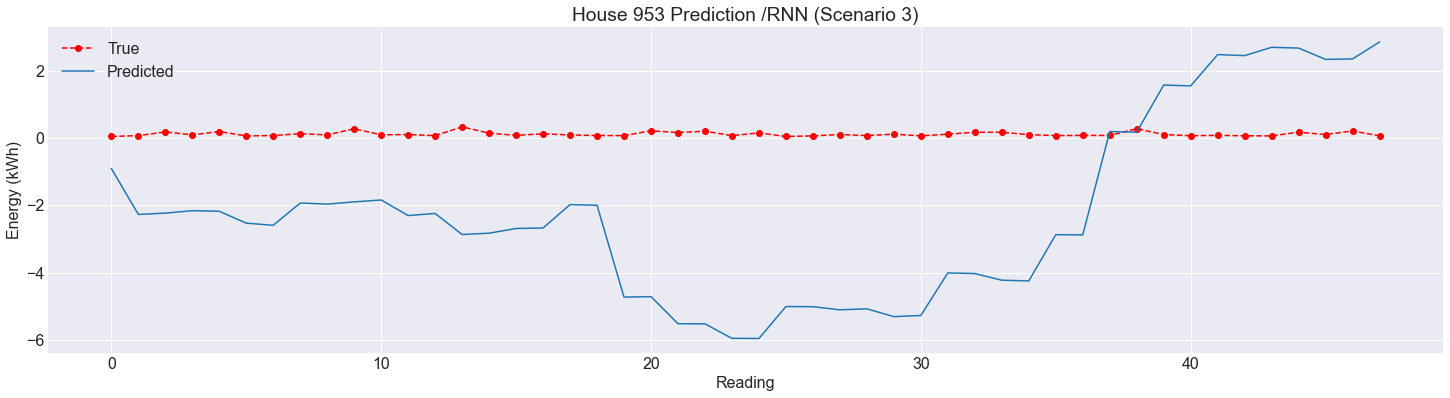

Mse:  2685.655079104176821
Rmse: 51.823306331265442
Mae:  51.789725888520479
Mape:  100.346451624182990


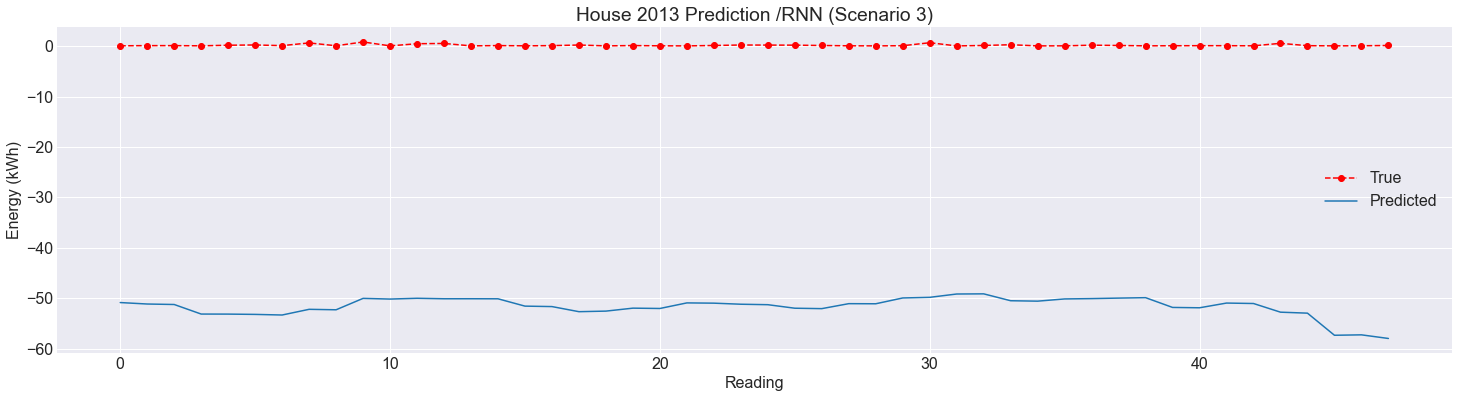

Mse:  353196.275121518410742
Rmse: 594.303184512348366
Mae:  594.274968354225507
Mape:  100.018473044412474


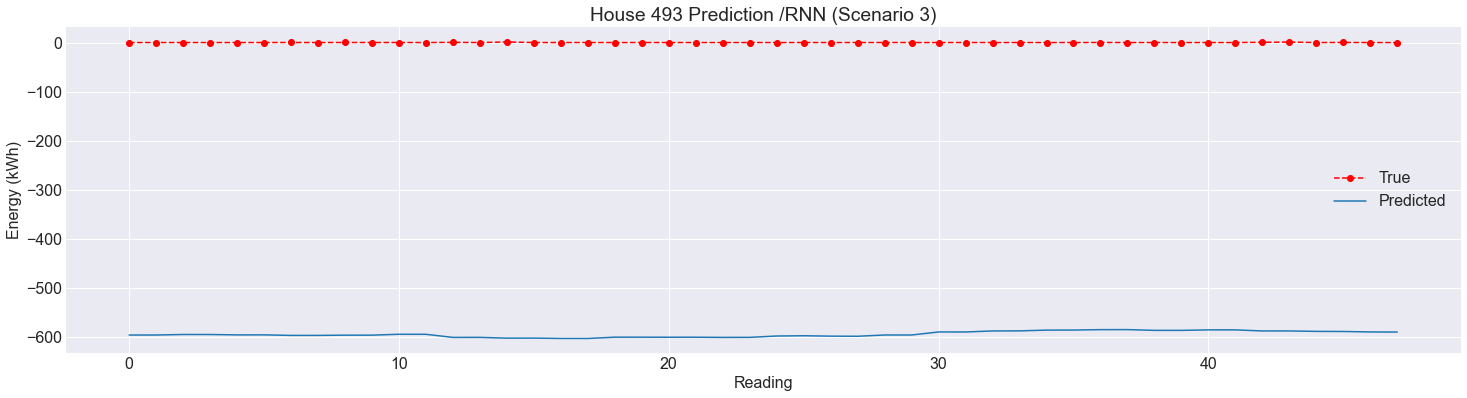

Mse:  187730.512004241114482
Rmse: 433.278792469976679
Mae:  433.278228627517819
Mape:  100.076000239686152


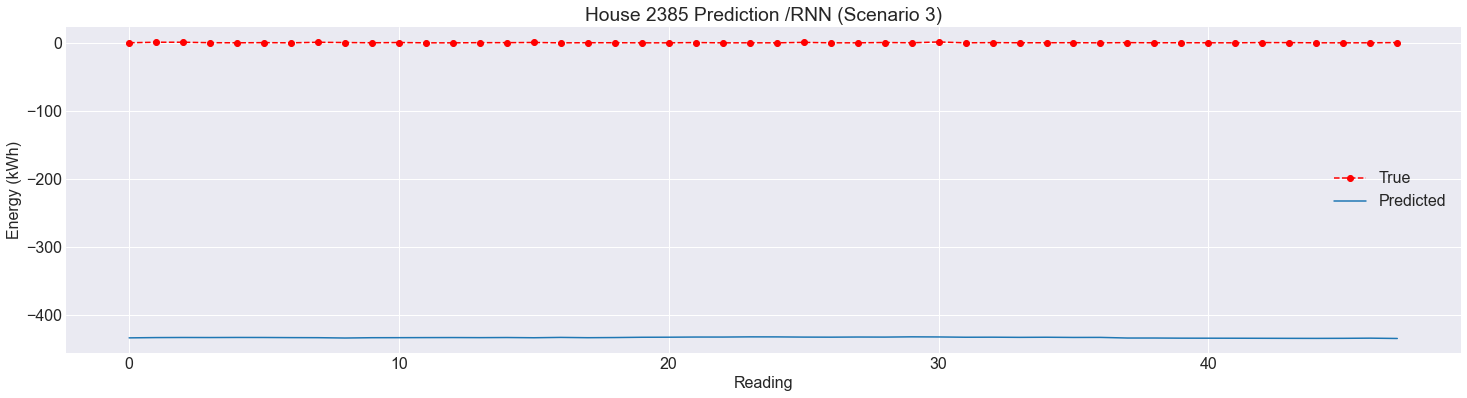

Mse:  14428.248101765449974
Rmse: 120.117642758112140
Mae:  120.107895940309390
Mape:  100.166420262460406


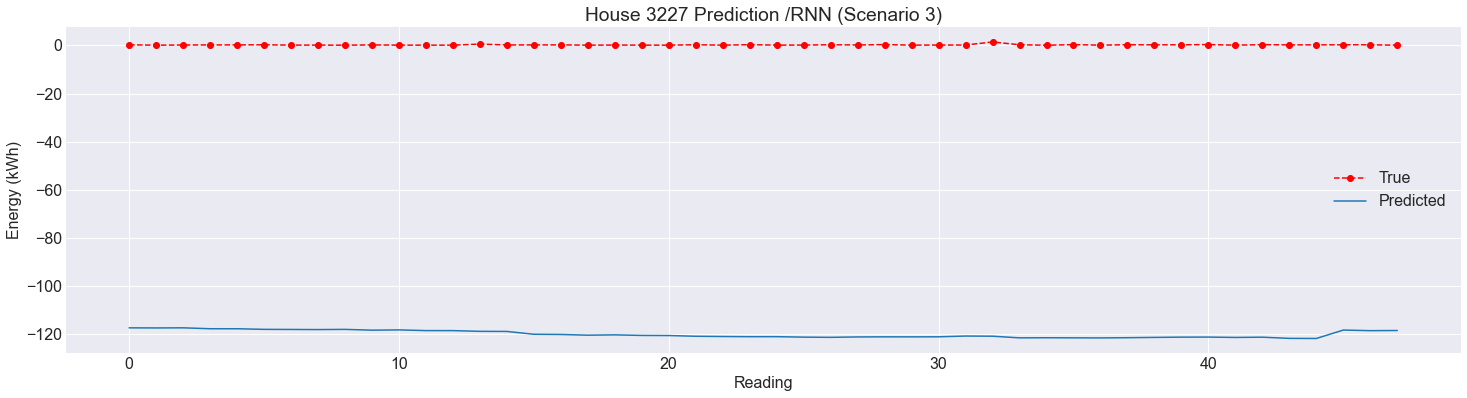

Mse:  29272.009030502318637
Rmse: 171.090645654583682
Mae:  170.999941270410403
Mape:  99.910046505010385


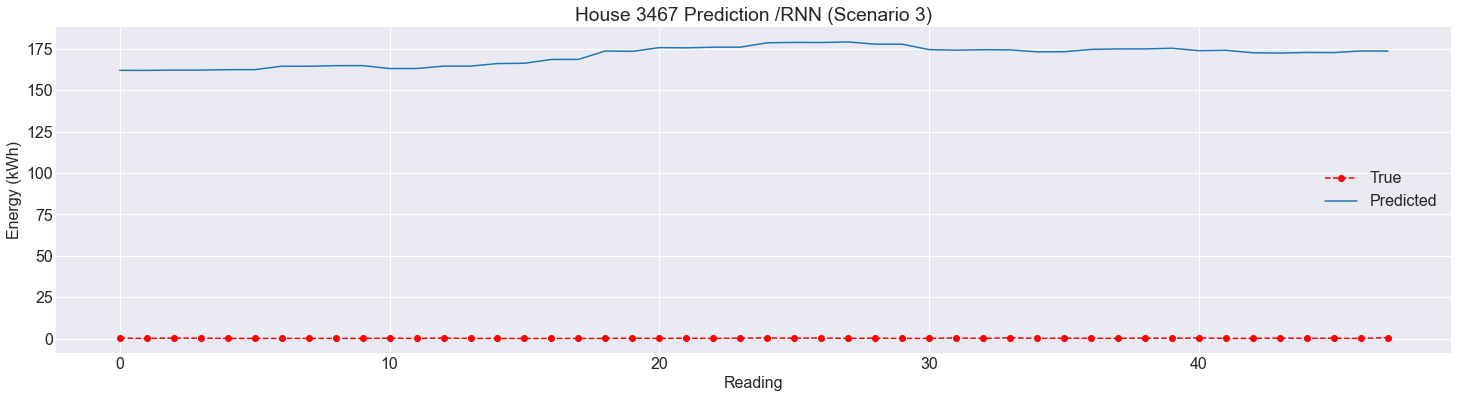

Mse:  38155.901212287222734
Rmse: 195.335355766147018
Mae:  195.330138896436750
Mape:  100.297509070140606


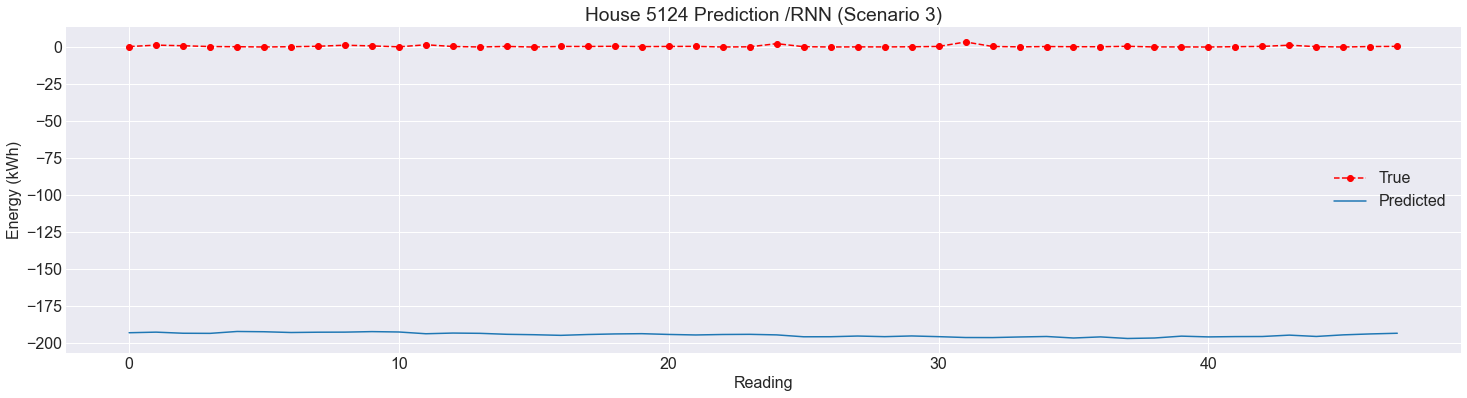

Mse:  684.948997638551305
Rmse: 26.171530288436543
Mae:  26.072627403462928
Mape:  98.674868464519562


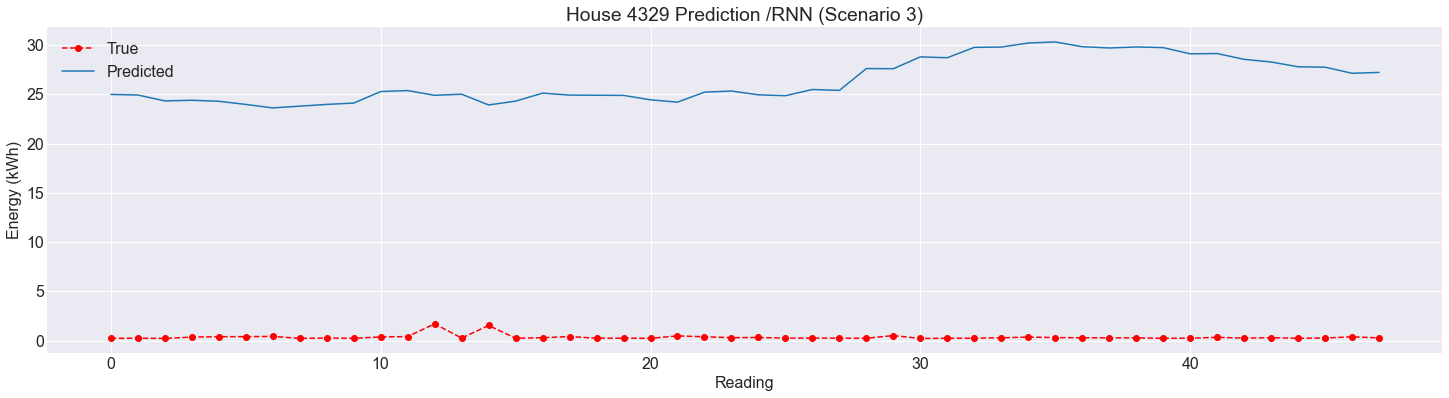

In [112]:
 ##### The households with an error have a '#' 

predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)

In [ ]:
models_performances_HH_level = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level

In [ ]:
models_performances_HH_level.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario3.csv', index=False)

In [ ]:
## Best regression model

In [113]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [114]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-48), :]
  test = reframed[(len(reframed)-48):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]


  model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
  model.fit(train_X, train_y)

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /SVR (Scenario 3)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario3/2_singleHouseholdLevel/best_regression_model/S3_24h_SVR_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


In [115]:
 ##### The households with an error have a '#' 


predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
models_performances_HH_level_Regression = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level_Regression

,HH_1,HH_2,HH_3,HH_4,HH_5,HH_6,HH_7,HH_8,HH_9,HH_10,...,HH_20,HH_21,HH_22,HH_23,HH_24,HH_25,HH_26,HH_27,HH_28,HH_29
MSE_scores,0.274801,0.334544,0.313381,0.018902,0.005334,0.182810,0.216139,0.005619,0.162033,0.210695,...,0.119716,0.065969,0.004228,0.048264,0.094442,0.193597,0.048692,0.073668,0.517323,0.065007
RMSE_scores,0.524215,0.578398,0.559804,0.137484,0.073032,0.427563,0.464908,0.074957,0.402534,0.459015,...,0.346000,0.256845,0.065021,0.219690,0.307315,0.439997,0.220663,0.271418,0.719252,0.254964
MAE_scores,0.483291,0.528701,0.439754,0.099580,0.044171,0.370807,0.400070,0.065663,0.281474,0.393145,...,0.270845,0.229689,0.052066,0.161530,0.225306,0.343288,0.144439,0.238891,0.587947,0.166621
MAPE_scores,72.650308,213.783640,159.523138,329.033947,86.971697,516.199675,301.142934,47.896403,173.125669,783.121505,...,183.941062,67.017659,41.718125,748.607426,406.323954,778.914101,50.944813,1645.716526,111.529880,84.847758


In [ ]:
models_performances_HH_level_Regression.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario3_SVR.csv', index=False)